# Analyse non-CO2 emission trends in the AR6 database
This script requires AR6 in both harmonised and non-harmonised formats, and takes EDGAR and RCMIP data as additional inputs. These are expected to be in the "./input" folder. 

In [1]:
import aneris
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import pyam
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf

<IPython.core.display.Javascript object>

In [2]:
version = "v6"

In [3]:
# Do we include a local, non-linear quantile fit in the plot? Referred to as "quantile rolling windows". 
include_qrw = False
if include_qrw:
    from silicone.stats import rolling_window_find_quantiles
# Do we start off with unharmonised emissions as the input or harmonised? Variables are harmonised later either way.
# Using unharmonised values allows for filtering out emissions values that might have been smoothed over in the 
# AR6 harmonisation analysis
use_unharm = True

In [4]:
ar6 = pyam.IamDataFrame("input/AR6_Scenarios_Database_World_v1.1.csv")

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file input\AR6_Scenarios_Database_World_v1.1.csv


In [5]:
ar6harm = pyam.IamDataFrame("input/1652361598937-ar6_emissions_vetted_infillerdatabase_10.5281-zenodo.6390768.csv")

pyam.core - INFO: Reading file input\1652361598937-ar6_emissions_vetted_infillerdatabase_10.5281-zenodo.6390768.csv


In [6]:
ar6harm

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : AIM/CGE 2.0, AIM/CGE 2.1, AIM/CGE 2.2, ... WITCH-GLOBIOM 4.4 (49)
 * scenario : 1.5C, 2.5C, 20% abatement (FF&I), ... WB2C (636)
Timeseries data coordinates:
   region   : World (1)
   variable : AR6 climate diagnostics|Harmonized|Emissions|BC, ... (26)
   unit     : Mt BC/yr, Mt CH4/yr, Mt CO/yr, Mt CO2/yr, Mt NH3/yr, ... kt SF6/yr (22)
   year     : 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, ... 2100 (86)
Meta indicators:
   exclude (bool) False (1)

In [7]:
len(ar6.filter(variable="Emissions|CO2").timeseries())

1871

In [8]:
ar6harm = ar6harm.rename(
    {"variable":{v: v.replace("AR6 climate diagnostics|Harmonized|", "") for v in ar6harm.variable}})

In [9]:
len(ar6harm.filter(variable="Emissions|CO2").timeseries())

1287

In [10]:
metadata = pd.read_excel("input/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name="meta_Ch3vetted_withclimate")

In [11]:
metadata = metadata.rename(columns={"Model": "model", "Scenario": "scenario"}).set_index(["model", "scenario"])

In [12]:
peak = "Median peak warming (FaIRv1.6.2)"

In [13]:
ch4 = "Emissions|CH4"
ch4afolu = "Emissions|CH4|AFOLU"
n2o = "Emissions|N2O"
bc = "Emissions|BC"
sulfur = "Emissions|Sulfur"
fgases = "Emissions|F-Gases"

if use_unharm:
    # There's bad data in a few scenarios
    constCH4 = ar6.filter(variable=ch4).filter(model="TIAM-UCL*", scenario="*CCC2020", keep=False)
    constn2o = ar6.filter(variable=n2o).filter(model="TIAM-UCL*", scenario="*CCC2020", keep=False)
    ar6ch4afolu = ar6.filter(variable=ch4afolu).filter(model=["IMACLIM*", 'MAgPIE 4.2'], keep=False)
    constBC = ar6.filter(variable=bc)
    constsulf = ar6.filter(variable=sulfur)
    constCH4 = constCH4.interpolate(range(2000, 2051))
    constn2o = constn2o.interpolate(range(2000, 2051))
else:
    constCH4 = ar6harm.filter(variable=ch4)
    constn2o = ar6harm.filter(variable=n2o)
    # AFOLU data is not available in the harmonised dataset
    ar6ch4afolu = ar6.filter(variable=ch4afolu).filter(model=["IMACLIM*", 'MAgPIE 4.2'], keep=False)
    constBC = ar6harm.filter(variable=bc)
    constsulf = ar6harm.filter(variable=sulfur)
    constCH4 = constCH4.interpolate(range(2000, 2051)).timeseries()
    constn2o = constn2o.interpolate(range(2000, 2051)).timeseries()
    constCH4.iloc[:10, :].T.plot()
    plt.legend( bbox_to_anchor=(1, 1))

In [14]:
converge_year = 2080
harm_year = 2015
if use_unharm:
    harm_dict = {ch4: constCH4, n2o: constn2o, bc: constBC, sulfur: constsulf}
    for toharm, unharmed_df in harm_dict.items():
        unharmed_df = unharmed_df.interpolate(harm_year).timeseries()
        histtoharmto = ar6harm.filter(variable=toharm, model="MESSAGE-GLOBIOM 1.0", scenario="SSP2-45").timeseries()
        for i in [j for j in unharmed_df.columns if j<harm_year]:
            unharmed_df[i] = unharmed_df[i].values[0]
        ratio = unharmed_df[harm_year].values[0] / unharmed_df[harm_year]
        for i in [j for j in unharmed_df.columns if (j>=harm_year) and (j<converge_year)]:
            unharmed_df[i] *= (ratio - 1) * (1 - (i - harm_year) / (converge_year - harm_year)) + 1
        harm_dict[toharm] = unharmed_df
    constCH4 = harm_dict[ch4]
    constn2o = harm_dict[n2o]
    constBC = harm_dict[bc]
    constsulf = harm_dict[sulfur]

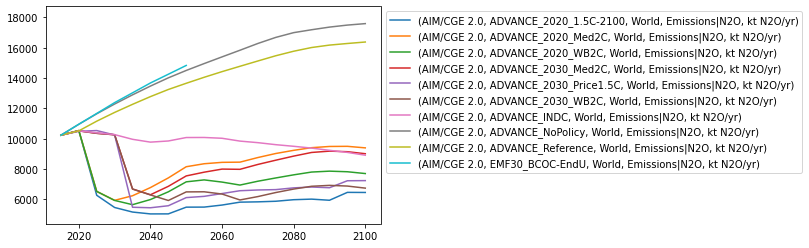

In [15]:
constn2o.iloc[:10, 15:].T.plot()
plt.legend( bbox_to_anchor=(1, 1))

In [16]:
# Ensure that the RCMIP database is present if running remotely, and load it!
# We only need the CH4 data from this, so a smaller file, or the data directly from PRIMAP would also work. 
rcmip = pyam.IamDataFrame("./input/rcmip-emissions-annual-means-v5-1-0.csv")

pyam.core - INFO: Reading file input\rcmip-emissions-annual-means-v5-1-0.csv


In [17]:
# Need historic record for 2000 to calculate GWP* for methane.
histch4 = rcmip.filter(variable=ch4, scenario="historical", region="World").timeseries()
histch4

1750  \
model               scenario   region variable      unit      mip_era activity_id                 
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  19.019783   

                                                                                           1751  \
model               scenario   region variable      unit      mip_era activity_id                 
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  18.915109   

                                                                                           1752  \
model               scenario   region variable      unit      mip_era activity_id                 
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  18.889712   

                                                                                           1753  \
model               scenario   region variable      unit      mip_era activity_id                 
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  19.121377   

                                                                                           1754  \
model               scenario   region variable      unit      mip_era activity_id                 
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  19.509061   

                                                                                           1755  \
model               scenario   region variable      unit      mip_era activity_id                 
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  19.500455   

                                                                                           1756  \
model               scenario   region variable      unit      mip_era activity_id                 
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  19.462537   

                                                                                           1757  \
model               scenario   region variable      unit      mip_era activity_id                 
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  20.023541   

                                                                                           1758  \
model               scenario   region variable      unit      mip_era activity_id                 
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  19.934005   

                                                                                           1759  \
model               scenario   region variable      unit      mip_era activity_id                 
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  20.141466   

                                                                                      ...  \
model               scenario   region variable      unit      mip_era activity_id     ...   
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  ...   

                                                                                            2005  \
model               scenario   region variable      unit      mip_era activity_id                  
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  346.395555   

                                                                                           2006  \
model               scenario   region variable      unit      mip_era activity_id                 
CEDS/UVA/GCP/PRIMAP historical World  Emissions|CH4 Mt CH4/yr CMIP6   not_applicable  356.46969   

                                                                                            2007  \
model               scenario   region variable      unit      mip_era activity_id                  
CEDS/UVA/GCP/PRIMAP historical W

In [18]:
# We require a separate database to estimate historic CH4 from AFOLU. We will only use the ratios from this. 
edgar = pd.read_excel("./input/EDGAR_CH4_1970-2021.xlsx", sheet_name="IPCC 2006", header=10)
edgar

IPCC_annex       C_group_IM24_sh Country_code_A3      Name  \
0     Non-Annex_I  Rest Central America             ABW     Aruba   
1     Non-Annex_I  Rest Central America             ABW     Aruba   
2     Non-Annex_I  Rest Central America             ABW     Aruba   
3     Non-Annex_I  Rest Central America             ABW     Aruba   
4     Non-Annex_I  Rest Central America             ABW     Aruba   
...           ...                   ...             ...       ...   
4624  Non-Annex_I       Southern_Africa             ZWE  Zimbabwe   
4625  Non-Annex_I       Southern_Africa             ZWE  Zimbabwe   
4626  Non-Annex_I       Southern_Africa             ZWE  Zimbabwe   
4627  Non-Annex_I       Southern_Africa             ZWE  Zimbabwe   
4628  Non-Annex_I       Southern_Africa             ZWE  Zimbabwe   

     ipcc_code_2006_for_standard_report  \
0                               1.A.1.a   
1                                 1.A.2   
2                                 1.A.4   
3                                 1.A.5   
4                                 1.B.1   
...                                 ...   
4624                              3.A.2   
4625                              3.C.7   
4626                                4.A   
4627                                4.C   
4628                                4.D   

            ipcc_code_2006_for_standard_report_name Substance fossil_bio  \
0     Main Activity Electricity and Heat Production       CH4        bio   
1         Manufacturing Industries and Construction       CH4        bio   
2                     Residential and other sectors       CH4        bio   
3                                     Non-Specified       CH4        bio   
4                                       Solid Fuels       CH4        bio   
...                                             ...       ...        ...   
4624                              Manure Management       CH4     fossil   
4625                              Rice cultivations       CH4     fossil   
4626                           Solid Waste Disposal       CH4     fossil   
4627         Incineration and Open Burning of Waste       CH4     fossil   
4628             Wastewater Treatment and Discharge       CH4     fossil   

         Y_1970     Y_1971  ...     Y_2012     Y_2013     Y_2014     Y_2015  \
0      0.000007   0.000006  ...   0.000401   0.000711   0.000749   0.000891   
1      0.003669   0.003507  ...   0.002957   0.002066   0.002067   0.002214   
2      0.002518   0.002415  ...   0.013824   0.012871   0.014356   0.012984   
3      0.000145   0.000140  ...   0.004678   0.004692   0.005013   0.005642   
4      0.004200   0.004124  ...   0.064706   0.059231   0.063548   0.065383   
...         ...        ...  ...        ...        ...        ...        ...   
4624   6.032490   6.408750  ...   8.403063   8.467443   6.642646   7.306212   
4625   0.552673   0.535199  ...   0.360523   0.376685   0.477855   0.588697   
4626   3.588168   4.270421  ...  23.182777  23.658698  24.056083  24.417312   
4627   0.041964   0.043220  ...   0.149427   0.149427   0.057312   0.057312   
4628  23.684297  24.612728  ...  65.730131  67.167554  68.444204  70.076844   

         Y_2016     Y_2017     Y_2018     Y_2019     Y_2020     Y_2021  
0      0.000732   0.000753   0.000929   0.000977   0.001014   0.001014  
1      0.002356   0.002878   0.002285   0.002357   0.002513   0.002513  
2      0.014027   0.013960   0.014064   0.010886   0.016769   0.016769  
3      0.005375   0.005614   0.005825   0.005671   0.006547   0.006547  
4      0.061914   0.063464   0.064291   0.067368   0.070345   0.070345  
...         ...        ...        ...        ...        ...        ...  
4624   7.430417   7.211478   7.277656   7.447917   7.608971   7.776668  
4625   0.481036   0.515905   0.528504   0.508524   0.517687   0.503485  
4626  24.821209  25.562763  26.174830  26.697502  27.230612  27.797454  
4627   0.031156   0.004999  -0.021157  -0.021157  -0.021157  -0.02115

In [19]:
histn2o = rcmip.filter(variable=n2o, scenario="historical", region="World").timeseries()
ch4afoluhist_edgar = edgar.loc[[i[0]=="3" for i in edgar["ipcc_code_2006_for_standard_report"]], :].sum()
ch4hist_edgar = edgar.sum()
ch4afoluratio = ch4afoluhist_edgar[8:]/ch4hist_edgar[8:]
histch4afolu = rcmip.filter(variable=ch4, scenario="historical", region="World").timeseries()
histch4afolu[2015] = ar6harm.filter(variable=ch4, scenario="SSP2-45", model="MES*", year=2015).timeseries()[2015].values
for i in range(2000, 2016):
    histch4afolu[i] *= ch4afoluratio["Y_" + str(i)]
histch4afolu = histch4afolu.reset_index()
histch4afolu["variable"] = ch4afolu
del histch4afolu["mip_era"]
del histch4afolu["activity_id"]
histch4afolu = pyam.IamDataFrame(histch4afolu)
histch4afolu

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : CEDS/UVA/GCP/PRIMAP (1)
 * scenario : historical (1)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|CH4|AFOLU (1)
   unit     : Mt CH4/yr (1)
   year     : 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, ... 2015 (266)
Meta indicators:
   exclude (bool) False (1)

In [20]:
# Also determine CH4 from AFOLU
converge_year = 2080
harm_year = 2015
harmedar6ch4afolu = ar6ch4afolu.interpolate(harm_year).timeseries()
histch4afoluts = histch4afolu.timeseries()
for i in [j for j in harmedar6ch4afolu.columns if j<harm_year]:
    harmedar6ch4afolu[i] = histch4afoluts[i].values[0]
ratio = histch4afoluts[harm_year].values[0] / harmedar6ch4afolu[harm_year]
for i in [j for j in harmedar6ch4afolu.columns if (j>=harm_year) and (j<converge_year)]:
    harmedar6ch4afolu[i] *= (ratio - 1) * (1 - (i - harm_year) / (converge_year - harm_year)) + 1
harmedar6ch4afolu = pyam.IamDataFrame(harmedar6ch4afolu)

harmedar6ch4afolu

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : AIM/CGE 2.0, AIM/CGE 2.1, AIM/CGE 2.2, ... WITCH-GLOBIOM 4.4 (45)
 * scenario : 1.5C, 1.5C A, 1.5C B, 1.5C C, 2.5C, ... WB2C (644)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|CH4|AFOLU (1)
   unit     : Mt CH4/yr (1)
   year     : 2000, 2005, 2010, 2011, 2012, 2013, 2014, 2015, ... 2100 (25)
Meta indicators:
   exclude (bool) False (1)

In [21]:
harmedar6ch4afolu.timeseries()

2000  \
model             scenario               region variable            unit                    
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4|AFOLU Mt CH4/yr  140.217063   
                  ADVANCE_2020_Med2C     World  Emissions|CH4|AFOLU Mt CH4/yr  140.217063   
                  ADVANCE_2020_WB2C      World  Emissions|CH4|AFOLU Mt CH4/yr  140.217063   
                  ADVANCE_2030_Med2C     World  Emissions|CH4|AFOLU Mt CH4/yr  140.217063   
                  ADVANCE_2030_Price1.5C World  Emissions|CH4|AFOLU Mt CH4/yr  140.217063   
...                                                                                   ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CH4|AFOLU Mt CH4/yr  140.217063   
                  CD-LINKS_NPi2020_1000  World  Emissions|CH4|AFOLU Mt CH4/yr  140.217063   
                  CD-LINKS_NPi2020_1600  World  Emissions|CH4|AFOLU Mt CH4/yr  140.217063   
                  CD-LINKS_NPi2020_400   World  Emissions|CH4|AFOLU Mt CH4/yr  140.217063   
                  CD-LINKS_NoPolicy      World  Emissions|CH4|AFOLU Mt CH4/yr  140.217063   

                                                                                     2005  \
model             scenario               region variable            unit                    
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4|AFOLU Mt CH4/yr  152.959238   
                  ADVANCE_2020_Med2C     World  Emissions|CH4|AFOLU Mt CH4/yr  152.959238   
                  ADVANCE_2020_WB2C      World  Emissions|CH4|AFOLU Mt CH4/yr  152.959238   
                  ADVANCE_2030_Med2C     World  Emissions|CH4|AFOLU Mt CH4/yr  152.959238   
                  ADVANCE_2030_Price1.5C World  Emissions|CH4|AFOLU Mt CH4/yr  152.959238   
...                                                                                   ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CH4|AFOLU Mt CH4/yr  152.959238   
                  CD-LINKS_NPi2020_1000  World  Emissions|CH4|AFOLU Mt CH4/yr  152.959238   
                  CD-LINKS_NPi2020_1600  World  Emissions|CH4|AFOLU Mt CH4/yr  152.959238   
                  CD-LINKS_NPi2020_400   World  Emissions|CH4|AFOLU Mt CH4/yr  152.959238   
                  CD-LINKS_NoPolicy      World  Emissions|CH4|AFOLU Mt CH4/yr  152.959238   

                                                                                     2010  \
model             scenario               region variable            unit                    
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4|AFOLU Mt CH4/yr  162.394345   
                  ADVANCE_2020_Med2C     World  Emissions|CH4|AFOLU Mt CH4/yr  162.394345   
                  ADVANCE_2020_WB2C      World  Emissions|CH4|AFOLU Mt CH4/yr  162.394345   
                  ADVANCE_2030_Med2C     World  Emissions|CH4|AFOLU Mt CH4/yr  162.394345   
                  ADVANCE_2030_Price1.5C World  Emissions|CH4|AFOLU Mt CH4/yr  162.394345   
...                                                                                   ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CH4|AFOLU Mt CH4/yr  162.394345   
                  CD-LINKS_NPi2020_1000  World  Emissions|CH4|AFOLU Mt CH4/yr  162.394345   
                  CD-LINKS_NPi2020_1600  World  Emissions|CH4|AFOLU Mt CH4/yr  162.394345   
                  CD-LINKS_NPi2020_400   World  Emissions|CH4|AFOLU Mt CH4/yr  162.394345   
                  CD-LINKS_NoPolicy      World  Emissions|CH4|AFOLU Mt CH4/yr  162.394345   

                                                                                     2011  \
model             scenario               region variable            unit                    
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4|AFOLU Mt CH4/yr  160.539558   
                  ADVANCE_2020_Med2C     World  Emissions|CH4|AFOLU Mt CH4/yr  160.539558   
                  ADVANCE_2020_WB2C      World  Emissions|CH4|AFOLU Mt CH4/yr  160.

In [22]:
constCH4

2000  \
model             scenario               region variable      unit              
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2020_Med2C     World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2020_WB2C      World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2030_Med2C     World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2030_Price1.5C World  Emissions|CH4 Mt CH4/yr   NaN   
...                                                                       ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NPi2020_1000  World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NPi2020_1600  World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NPi2020_400   World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NoPolicy      World  Emissions|CH4 Mt CH4/yr   NaN   

                                                                         2001  \
model             scenario               region variable      unit              
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2020_Med2C     World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2020_WB2C      World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2030_Med2C     World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2030_Price1.5C World  Emissions|CH4 Mt CH4/yr   NaN   
...                                                                       ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NPi2020_1000  World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NPi2020_1600  World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NPi2020_400   World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NoPolicy      World  Emissions|CH4 Mt CH4/yr   NaN   

                                                                         2002  \
model             scenario               region variable      unit              
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2020_Med2C     World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2020_WB2C      World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2030_Med2C     World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2030_Price1.5C World  Emissions|CH4 Mt CH4/yr   NaN   
...                                                                       ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NPi2020_1000  World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NPi2020_1600  World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NPi2020_400   World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NoPolicy      World  Emissions|CH4 Mt CH4/yr   NaN   

                                                                         2003  \
model             scenario               region variable      unit              
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2020_Med2C     World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2020_WB2C      World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2030_Med2C     World  Emissions|CH4 Mt CH4/yr   NaN   
                  ADVANCE_2030_Price1.5C World  Emissions|CH4 Mt CH4/yr   NaN   
...                                                                       ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NPi2020_1000  World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD-LINKS_NPi2020_1600  World  Emissions|CH4 Mt CH4/yr   NaN   
                  CD

In [23]:
harmedar6ch4afolu = harmedar6ch4afolu.interpolate(range(2000, 2051)).timeseries()

for i in range(2000, 2015):
    constCH4[i] = histch4[i].values[0]
    harmedar6ch4afolu[i] = histch4afoluts[i].values[0]
    constn2o[i] = histn2o[i].values[0]
constCH4 = pyam.IamDataFrame(constCH4)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|CH4|Not AFOLU'}, xlabel='Year', ylabel='unknown'>

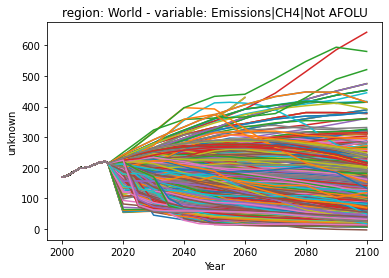

In [24]:
ch4notafolu = "Emissions|CH4|Not AFOLU"
constCH4.meta["exclude"] = True
# We only want scenarios with both parts in
harmedch4notafolu = pyam.concat(
    [pyam.IamDataFrame(harmedar6ch4afolu), constCH4], ignore_meta_conflict=True
).filter(exclude=False)
harmedch4notafolu = harmedch4notafolu.filter(year=range(2000, 2101)).subtract(ch4, ch4afolu, ch4notafolu, ignore_units=True)
harmedch4notafolu.plot()

In [25]:
harmedar6ch4afolu = pyam.IamDataFrame(harmedar6ch4afolu)

In [26]:
assert len(harmedch4notafolu.timeseries()) == len(harmedar6ch4afolu.timeseries())

In [27]:
harmedar6ch4afolu

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : AIM/CGE 2.0, AIM/CGE 2.1, AIM/CGE 2.2, ... WITCH-GLOBIOM 4.4 (45)
 * scenario : 1.5C, 1.5C A, 1.5C B, 1.5C C, 2.5C, ... WB2C (644)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|CH4|AFOLU (1)
   unit     : Mt CH4/yr (1)
   year     : 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, ... 2100 (61)
Meta indicators:
   exclude (bool) False (1)

In [28]:
harmedch4notafolu.timeseries()

2000  \
model             scenario               region variable                unit                  
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4|Not AFOLU unknown  169.969747   
                  ADVANCE_2020_Med2C     World  Emissions|CH4|Not AFOLU unknown  169.969747   
                  ADVANCE_2020_WB2C      World  Emissions|CH4|Not AFOLU unknown  169.969747   
                  ADVANCE_2030_Med2C     World  Emissions|CH4|Not AFOLU unknown  169.969747   
                  ADVANCE_2030_Price1.5C World  Emissions|CH4|Not AFOLU unknown  169.969747   
...                                                                                     ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CH4|Not AFOLU unknown  169.969747   
                  CD-LINKS_NPi2020_1000  World  Emissions|CH4|Not AFOLU unknown  169.969747   
                  CD-LINKS_NPi2020_1600  World  Emissions|CH4|Not AFOLU unknown  169.969747   
                  CD-LINKS_NPi2020_400   World  Emissions|CH4|Not AFOLU unknown  169.969747   
                  CD-LINKS_NoPolicy      World  Emissions|CH4|Not AFOLU unknown  169.969747   

                                                                                       2001  \
model             scenario               region variable                unit                  
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4|Not AFOLU unknown  171.677465   
                  ADVANCE_2020_Med2C     World  Emissions|CH4|Not AFOLU unknown  171.677465   
                  ADVANCE_2020_WB2C      World  Emissions|CH4|Not AFOLU unknown  171.677465   
                  ADVANCE_2030_Med2C     World  Emissions|CH4|Not AFOLU unknown  171.677465   
                  ADVANCE_2030_Price1.5C World  Emissions|CH4|Not AFOLU unknown  171.677465   
...                                                                                     ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CH4|Not AFOLU unknown  171.677465   
                  CD-LINKS_NPi2020_1000  World  Emissions|CH4|Not AFOLU unknown  171.677465   
                  CD-LINKS_NPi2020_1600  World  Emissions|CH4|Not AFOLU unknown  171.677465   
                  CD-LINKS_NPi2020_400   World  Emissions|CH4|Not AFOLU unknown  171.677465   
                  CD-LINKS_NoPolicy      World  Emissions|CH4|Not AFOLU unknown  171.677465   

                                                                                      2002  \
model             scenario               region variable                unit                 
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4|Not AFOLU unknown  175.84653   
                  ADVANCE_2020_Med2C     World  Emissions|CH4|Not AFOLU unknown  175.84653   
                  ADVANCE_2020_WB2C      World  Emissions|CH4|Not AFOLU unknown  175.84653   
                  ADVANCE_2030_Med2C     World  Emissions|CH4|Not AFOLU unknown  175.84653   
                  ADVANCE_2030_Price1.5C World  Emissions|CH4|Not AFOLU unknown  175.84653   
...                                                                                    ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CH4|Not AFOLU unknown  175.84653   
                  CD-LINKS_NPi2020_1000  World  Emissions|CH4|Not AFOLU unknown  175.84653   
                  CD-LINKS_NPi2020_1600  World  Emissions|CH4|Not AFOLU unknown  175.84653   
                  CD-LINKS_NPi2020_400   World  Emissions|CH4|Not AFOLU unknown  175.84653   
                  CD-LINKS_NoPolicy      World  Emissions|CH4|Not AFOLU unknown  175.84653   

                                                                                       2003  \
model             scenario               region variable                unit                  
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CH4|Not AFOLU unknown  182.031543   
                  ADVANCE_2020_Med2C     World  Emissions|CH4|Not AFOLU unknown  182.031543   
            

# Analyse F-gas data and filter bad values

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|F-Gases'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

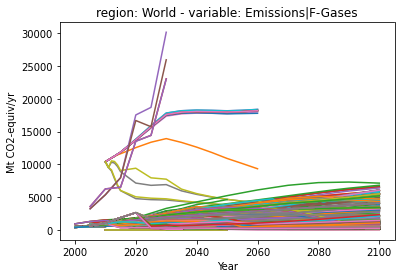

In [29]:
fgasdf = ar6.filter(variable=fgases).interpolate(2015)
fgasdf.plot()
# Unharmonised data contains invalid items.

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|F-Gases'}, xlabel='Year', ylabel='Mt CO2/yr'>

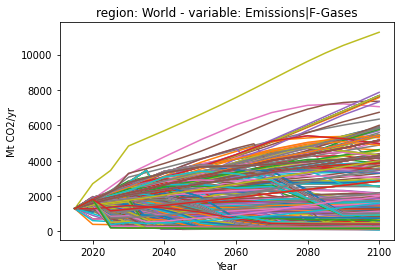

In [30]:
# Analyse problems with f-gas data and clean it for use.
harmfgasdf = ar6harm.filter(variable=fgases)
harmfgasdf.plot()
# Harmonised data seems fairly clean

In [31]:
fgasts = fgasdf.timeseries()
fgasts = fgasts.loc[~np.isnan(fgasts[2050]), :]

<AxesSubplot:>

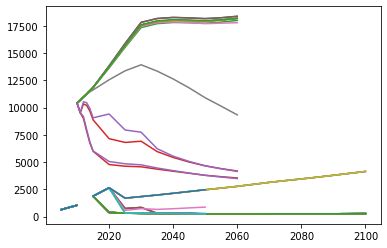

In [32]:
fgasts.loc[fgasts[2015] > 1800, :].T.plot(legend=None)

In [33]:
fgasts = fgasts.loc[fgasts[2015] < 1800, :]

<AxesSubplot:>

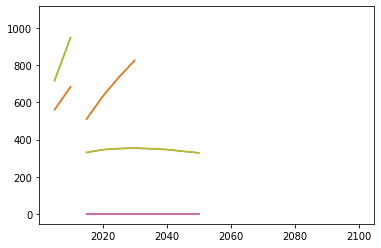

In [34]:
fgasts.loc[fgasts[2015] < 600, :].T.plot(legend=None)

In [35]:
fgasts = fgasts.loc[fgasts[2015] > 600, :]

<AxesSubplot:>

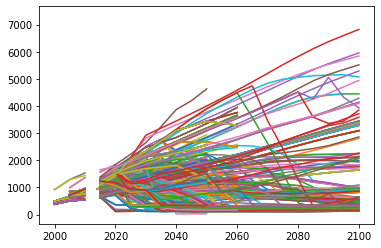

In [36]:
fgasts.T.plot(legend=None)

In [37]:
fgasdf = pyam.IamDataFrame(fgasts)

In [38]:
# freshly harmonise if required
if use_unharm:
    unharmed_df = fgasdf.interpolate(harm_year).timeseries()
    histtoharmto = ar6harm.filter(variable=fgases, model="MESSAGE-GLOBIOM 1.0", scenario="SSP2-45").timeseries()
    for i in [j for j in unharmed_df.columns if j<harm_year]:
        unharmed_df[i] = unharmed_df[i].values[0]
    ratio = unharmed_df[harm_year].values[0] / unharmed_df[harm_year]
    for i in [j for j in unharmed_df.columns if (j>=harm_year) and (j<converge_year)]:
        unharmed_df[i] *= (ratio - 1) * (1 - (i - harm_year) / (converge_year - harm_year)) + 1
    constFgas = unharmed_df
else:
    constFgas = harmfgasdf

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|F-Gases'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

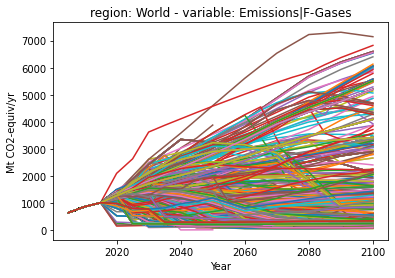

In [39]:
pyam.IamDataFrame(constFgas).plot()

# Plot the emissions reductions for each temperature

C:\Users\rlamboll\Anaconda3\envs\silicone-3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\rlamboll\Anaconda3\envs\silicone-3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\rlamboll\Anaconda3\envs\silicone-3\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


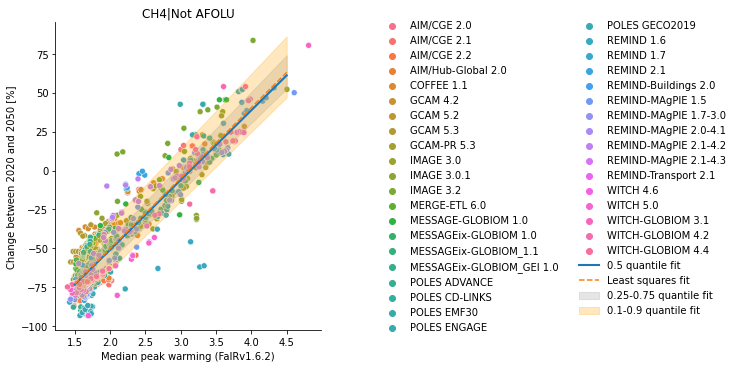

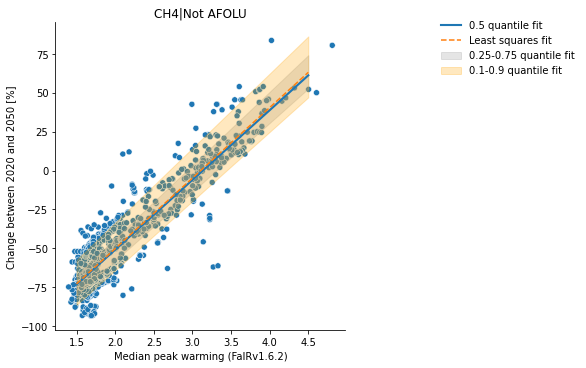

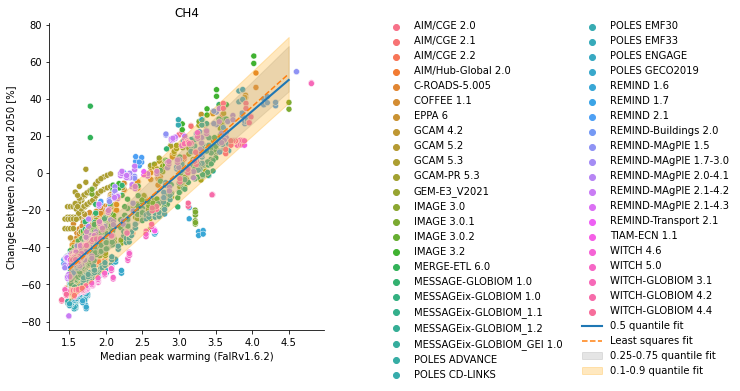

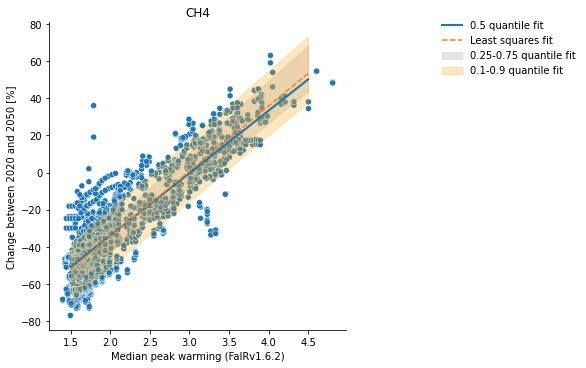

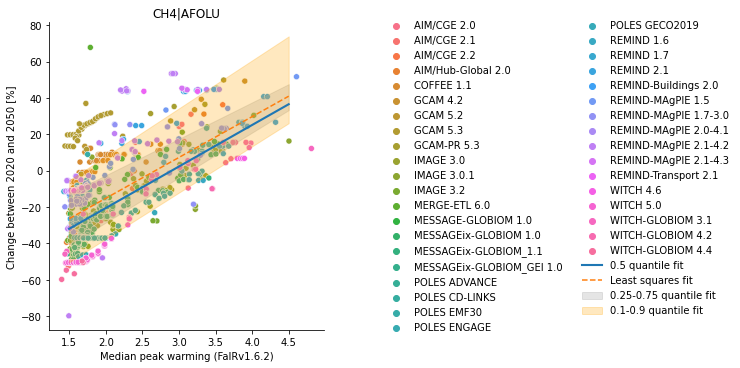

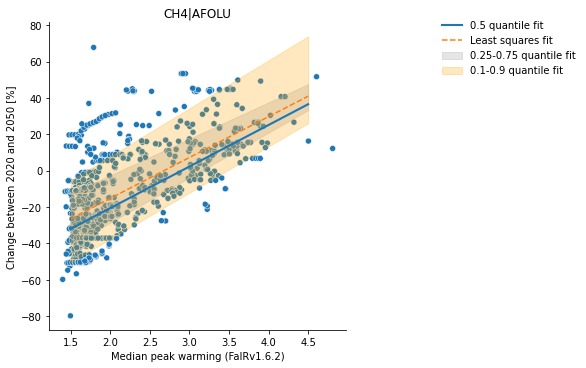

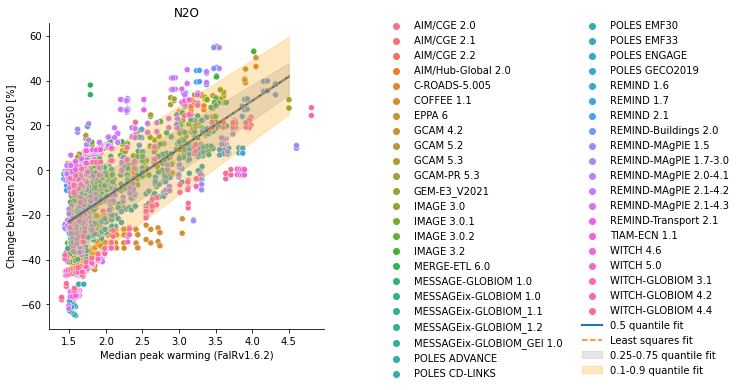

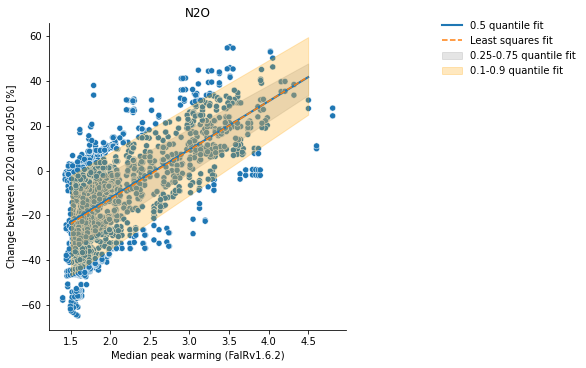

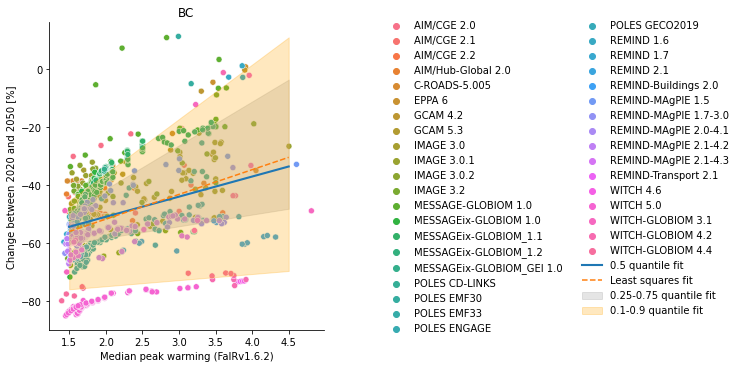

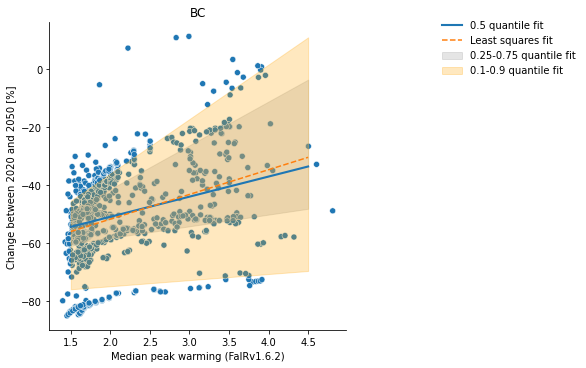

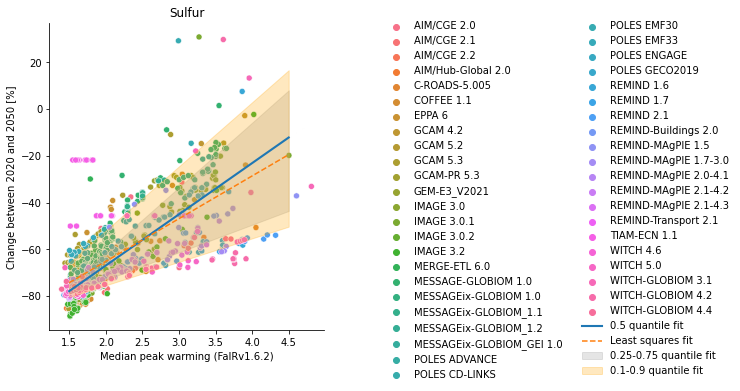

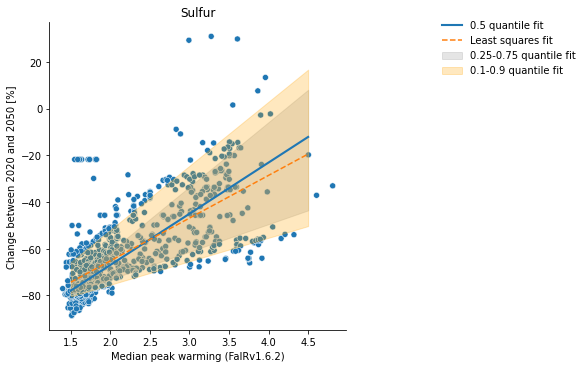

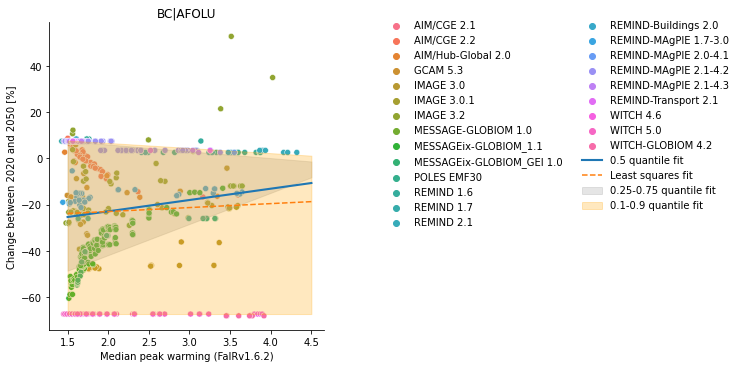

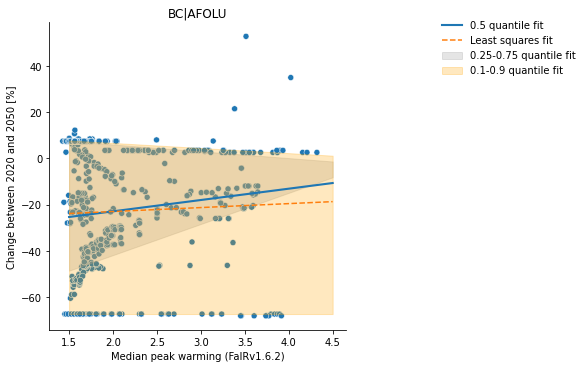

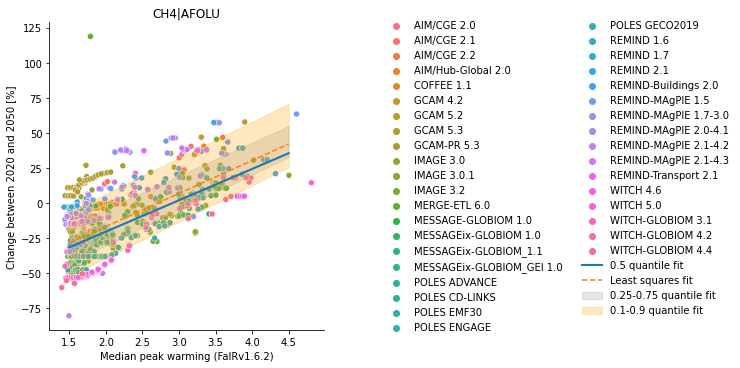

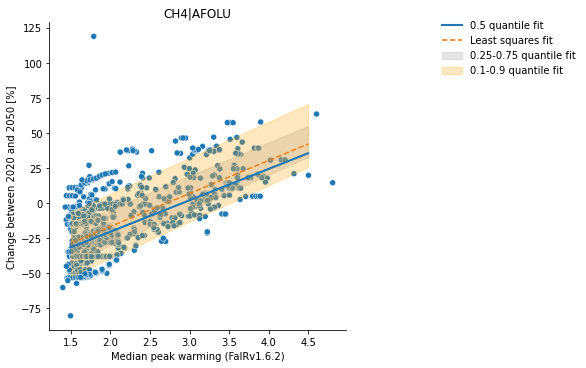

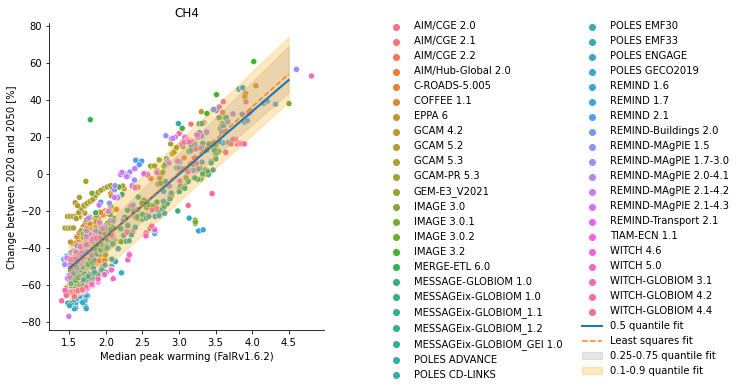

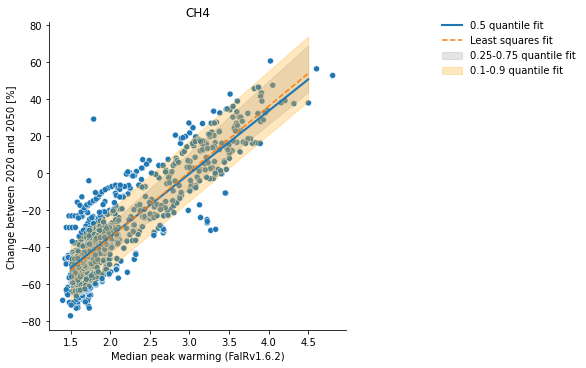

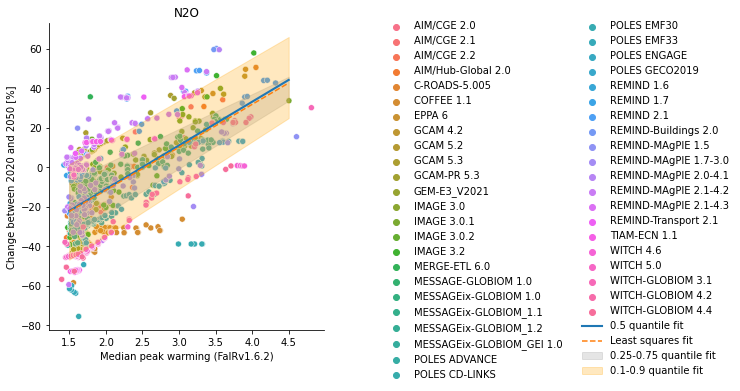

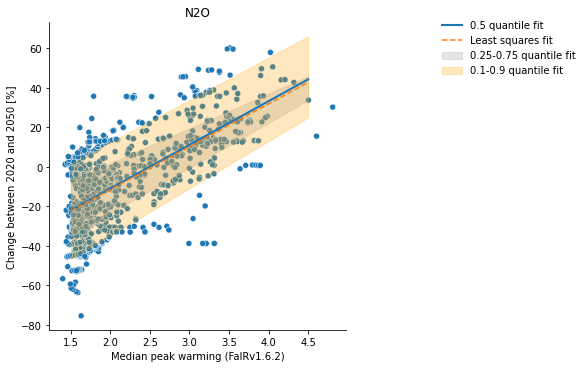

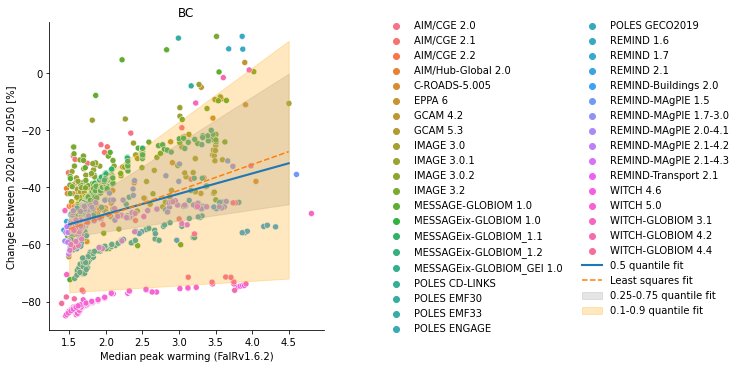

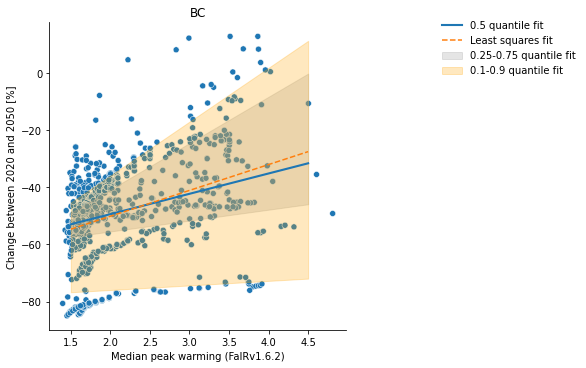

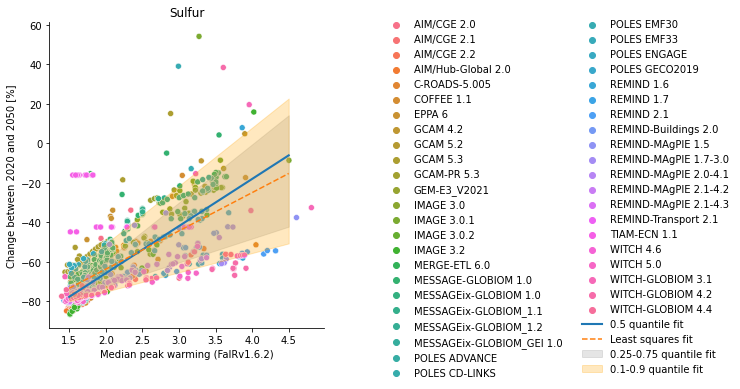

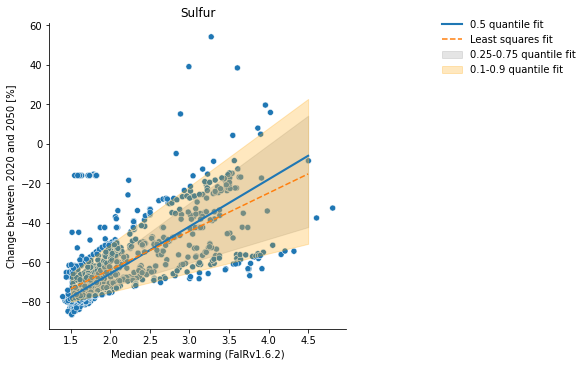

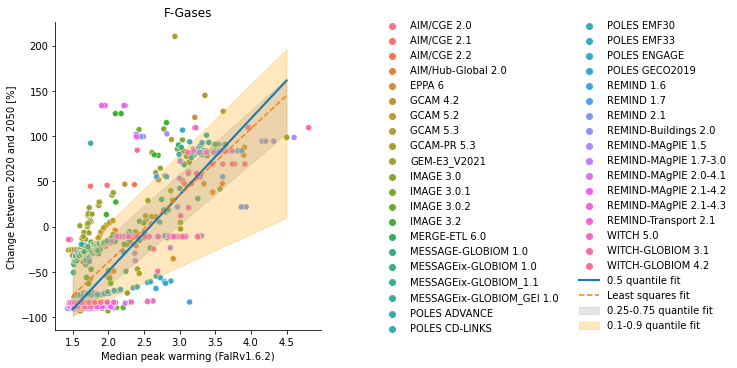

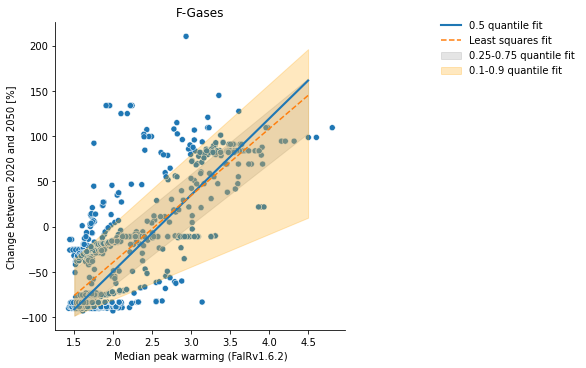

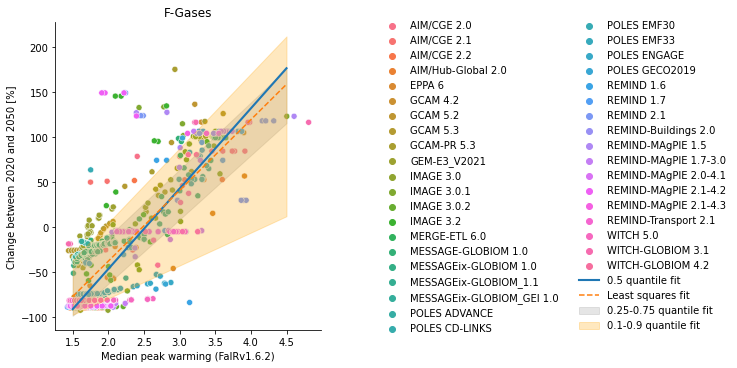

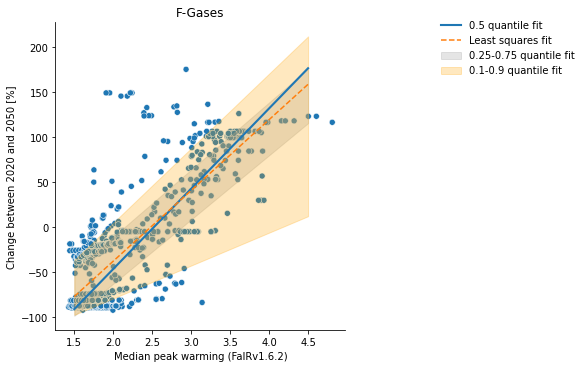

In [40]:
# Plot the set of ratios in 2050 to 2020 for a range of variables, with different harmonisations explored too.
alllinresults = {}
allquantresults = {}
temps_of_interest = np.arange(1.5, 4.6, 0.1)
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
os.makedirs("./output/figures/", exist_ok=True)
for var, db, harmstatus in [
    ("*CH4|Not AFOLU", harmedch4notafolu, "harm"), 
    ("*CH4", ar6, "unharm"), ("*CH4|AFOLU", ar6, "unharm"), ("*N2O", ar6, "unharm"),
    ("*BC", ar6, "unharm"), ("*Sulfur", ar6, "unharm"), ("*BC|AFOLU", ar6, "unharm"),
    ("*CH4|AFOLU", pyam.IamDataFrame(harmedar6ch4afolu), "harm"),
    ("*CH4", pyam.IamDataFrame(constCH4), "harm"), ("*N2O", pyam.IamDataFrame(constn2o), "harm"), 
    ("*BC", pyam.IamDataFrame(constBC), "harm"), ("*Sulfur", pyam.IamDataFrame(constsulf), "harm"),
    ("*F-Gases", fgasdf, "unharm"), ("*F-Gases", pyam.IamDataFrame(constFgas), "harm")
]:
    selec = db.filter(variable=var).timeseries().droplevel([2, 3, 4])
    rat = (selec[2050]/selec[2020] - 1) * 100
    rat.name = "Ratio"
    peakseries = pd.Series(metadata[peak], name=peak)
    varcompare = pd.merge(peakseries, rat, left_index=True, right_index=True)
    # linear least squares fit
    miv, biv = np.polyfit(varcompare[peak], varcompare["Ratio"], 1)
    alllinresults[var[1:]] = {t: miv*t+biv for t in temps_of_interest}
    
    # Plot this
    for hue in ["model", 1]:
        plot = sns.relplot(data=varcompare, x=peak, y="Ratio", hue=hue, kind="scatter").set(title=var[1:])
        plt.ylabel("Change between 2020 and 2050 [%]")
        # quantile fit
        allquant = {}
        for q in quantiles:
            qr = smf.quantreg('Ratio ~ Q(f"{peak}")', varcompare).fit(q=q)
            allquant[q] = {t: qr.params["Intercept"] + qr.params['Q(f"{peak}")'] * t for t in temps_of_interest}
        plt.plot(allquant[0.5].keys(), [i for i in allquant[0.5].values()], 
                     linestyle="-", label=f'{0.5} quantile fit', linewidth=2.1)
        plt.plot(alllinresults[var[1:]].keys(), alllinresults[var[1:]].values(), label="Least squares fit", linestyle="--")
        plt.fill_between(
            allquant[0.5].keys(), [i for i in allquant[0.25].values()], [i for i in allquant[0.75].values()],
            label=f'0.25-0.75 quantile fit', alpha=0.3, color="darkgrey"
        )    
        plt.fill_between(
            allquant[0.5].keys(), [i for i in allquant[0.1].values()], [i for i in allquant[0.9].values()],
            label=f'0.1-0.9 quantile fit', alpha=0.25, color="orange"
        )    
        allquantresults[(var[1:], harmstatus)] = allquant
        
        # sort legend out
        handles, labels = plot.axes[0][0].get_legend_handles_labels()
        plot._legend.remove()
        if hue != 1:
            lgd = plot.fig.legend(handles, labels, ncol=2, loc='upper center', 
                    bbox_to_anchor=(1.08, 1), frameon=False)
        else:
            lgd = plot.fig.legend(handles[1:], labels[1:], ncol=1, loc='upper left', 
                bbox_to_anchor=(1.1, 1), frameon=False)

        plt.savefig(
            f"./output/figures/quantileregression_fit_{var[1:].replace('|', '-')}_{harmstatus}_hue_{hue}_{version}.png", 
            bbox_extra_artists=(lgd,), bbox_inches='tight'
        )
        plt.savefig(
            f"./output/figures/quantileregression_fit_{var[1:].replace('|', '-')}_{harmstatus}_hue_{hue}_{version}.pdf", 
            bbox_extra_artists=(lgd,), bbox_inches='tight'
        )

In [41]:
# Decode some of the values stored above
quantdf = []
for (key1a, key1b), inner_dict in allquantresults.items():
    # Iterate over the second level dictionaries
    for key2, inner_inner_dict in inner_dict.items(): 
        # Create a new dictionary with the flattened entries
        for key3, val in inner_inner_dict.items():
            flattened_entry = {
                'Gas': key1a,
                "harmonisation": key1b,
                'Quantile': key2,
                "temperature": key3,
                "ratio": val
            }
            # Append the flattened entry to the list
            quantdf.append(flattened_entry)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(quantdf)
df

Gas harmonisation  Quantile  temperature       ratio
0     CH4|Not AFOLU          harm       0.1          1.5  -86.220276
1     CH4|Not AFOLU          harm       0.1          1.6  -81.779822
2     CH4|Not AFOLU          harm       0.1          1.7  -77.339367
3     CH4|Not AFOLU          harm       0.1          1.8  -72.898913
4     CH4|Not AFOLU          harm       0.1          1.9  -68.458458
...             ...           ...       ...          ...         ...
2165        F-Gases          harm       0.9          4.1  178.935683
2166        F-Gases          harm       0.9          4.2  187.226390
2167        F-Gases          harm       0.9          4.3  195.517098
2168        F-Gases          harm       0.9          4.4  203.807805
2169        F-Gases          harm       0.9          4.5  212.098512

[2170 rows x 5 columns]

In [42]:
os.makedirs("./output/", exist_ok=True)
df.to_csv(f"./output/gasQuantileTempReductionFactor2020-2050{version}.csv")

In [45]:
# Repeat for 2040 and 2030 ratios
alllinresults = {}
allquantresults = {}
temps_of_interest = np.arange(1.5, 4.6, 0.1)
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
os.makedirs("./output/figures/", exist_ok=True)
for year in [2030, 2040]:
    for var, db, harmstatus in [
        ("*CH4|Not AFOLU", harmedch4notafolu, "harm"), 
        ("*CH4", ar6, "unharm"), ("*CH4|AFOLU", ar6, "unharm"), ("*N2O", ar6, "unharm"),
        ("*BC", ar6, "unharm"), ("*Sulfur", ar6, "unharm"), ("*BC|AFOLU", ar6, "unharm"),
        ("*CH4|AFOLU", pyam.IamDataFrame(harmedar6ch4afolu), "harm"),
        ("*CH4", pyam.IamDataFrame(constCH4), "harm"), ("*N2O", pyam.IamDataFrame(constn2o), "harm"), 
        ("*BC", pyam.IamDataFrame(constBC), "harm"), ("*Sulfur", pyam.IamDataFrame(constsulf), "harm"),
        ("*F-Gases", fgasdf, "unharm"), ("*F-Gases", pyam.IamDataFrame(constFgas), "harm")
    ]:    
        selec = db.filter(variable=var).timeseries().droplevel([2, 3, 4])
        rat = (selec[year]/selec[2020]-1) * 100
        rat.name = "Ratio"
        peakseries = pd.Series(metadata[peak], name=peak)
        varcompare = pd.merge(peakseries, rat, left_index=True, right_index=True)
        # linear least squares fit
        miv, biv = np.polyfit(varcompare[peak], varcompare["Ratio"], 1)
        alllinresults[var[1:]] = {t: miv*t+biv for t in temps_of_interest}

        # Plot this
        allquant = {}
        for q in quantiles:
            qr = smf.quantreg('Ratio ~ Q(f"{peak}")', varcompare).fit(q=q)
            allquant[q] = {t: qr.params["Intercept"] + qr.params['Q(f"{peak}")'] * t for t in temps_of_interest}
        allquantresults[(var[1:], harmstatus)] = allquant
        quantdf = []
        for (key1a, key1b), inner_dict in allquantresults.items():
            # Iterate over the second level dictionaries
            for key2, inner_inner_dict in inner_dict.items(): 
                # Create a new dictionary with the flattened entries
                for key3, val in inner_inner_dict.items():
                    flattened_entry = {
                        'Gas': key1a,
                        "harmonisation": key1b,
                        'Quantile': key2,
                        "temperature": key3,
                        "ratio": val
                    }
                    # Append the flattened entry to the list
                    quantdf.append(flattened_entry)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(quantdf)
    df.to_csv(f"./output/YearlygasQuantileTempReductionFactor2020-{year}{version}.csv")

C:\Users\rlamboll\Anaconda3\envs\silicone-3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\rlamboll\Anaconda3\envs\silicone-3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\rlamboll\Anaconda3\envs\silicone-3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\rlamboll\Anaconda3\envs\silicone-3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


# Attempt a tolerance-window based approach to identifying the emissions reduction at exactly 1.5C

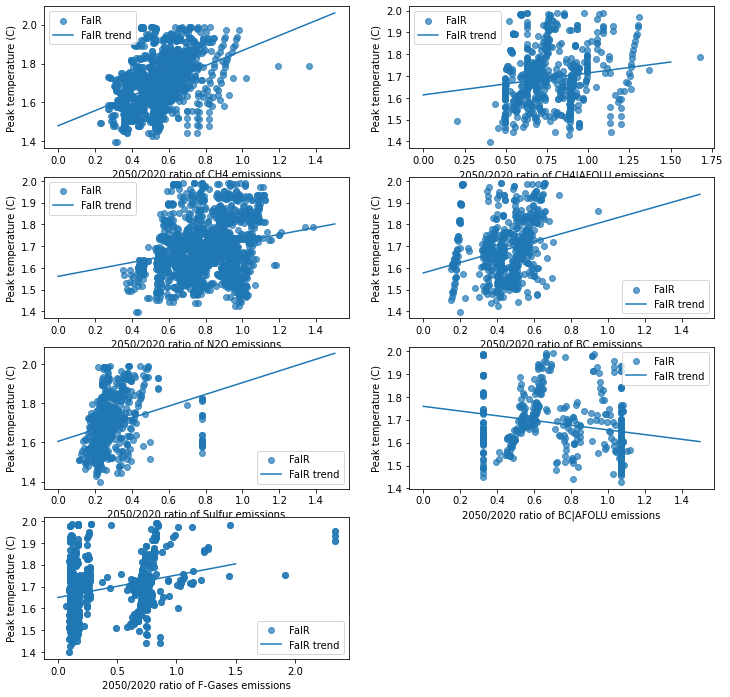

In [43]:
target=1.5
all_fair_results = {}
plt.figure(figsize=(12, 12))
i = 1
listvars = ["*CH4", "*CH4|AFOLU", "*N2O", "*BC", "*Sulfur", "*BC|AFOLU", "*F-Gases"]
for var in listvars:
    fair_results = {}
    selec = ar6.filter(variable=var).timeseries().droplevel([2, 3, 4])
    rat = selec[2050]/selec[2020]
    rat.name = "Ratio"
    peakseries = pd.Series(metadata[peak], name=peak)
    varcompare = pd.merge(peakseries, rat, left_index=True, right_index=True)
    for tol in np.arange(0.01, 0.5, 0.01):
        fair_scen = varcompare.loc[
            (varcompare[peak] > target-tol) & (varcompare[peak] < target+tol), :
        ]
        fairmiv, fairbiv = np.polyfit(fair_scen[rat.name], fair_scen[peak], 1)
        fair_results[tol] = (1.5 - fairbiv) / fairmiv
    all_fair_results[var[1:]] = fair_results
    plt.subplot(4, 2, i)
    i += 1
    plt.scatter(fair_scen[rat.name], fair_scen[peak], label="FaIR", alpha=0.7)
    x = [0, 1.5]
    plt.plot(x, [fairbiv + xi * fairmiv for xi in x], label="FaIR trend")
    plt.xlabel(f"2050/2020 ratio of {var[1:]} emissions")
    plt.ylabel("Peak temperature (C)")
    plt.legend()

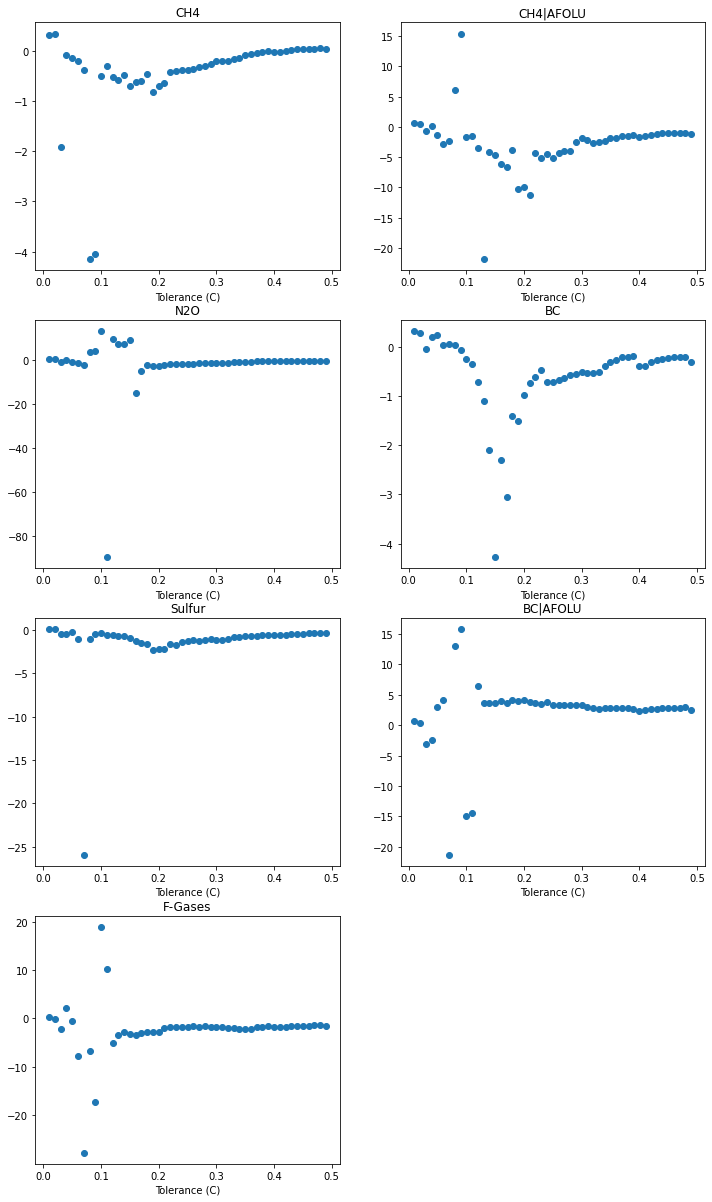

In [44]:
plt.figure(figsize=(12, 21))
i = 1
for var in listvars:
    plt.subplot(4, 2, i)
    i += 1
    plt.scatter(all_fair_results[var[1:]].keys(), all_fair_results[var[1:]].values())
    plt.title(var[1:])
    plt.xlabel("Tolerance (C)")
    plt.ylabel("")

The results are not particularly robust to tolerance change. 

# Calculate the contribution of continued methane emissions to temperature rise
Calculated using GWP* = {29.8 or 27.2} * (0.75 * 100 * dE/dt + 0.25 * E), depending on whether the methane is fossil or biogenic.

We compare this to a constant fractional reduction across the 2020-2040 period, assuming the SSP2-4.5 scenario is correct in 2020.

<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - scenario: SSP2-45 - region: World - variable: Emissions|CH4|AFOLU'}, xlabel='Year', ylabel='Mt CH4/yr'>

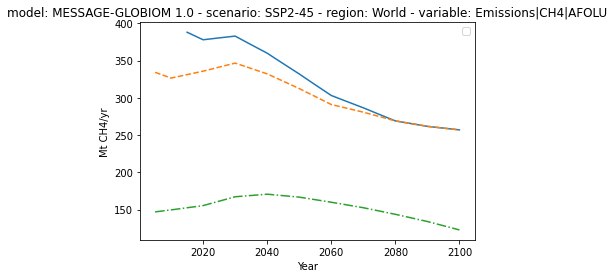

In [46]:
plt.figure()
ax = plt.subplot()
ar6harm.filter(variable=ch4, scenario="SSP2-45", model="MES*").plot(ax=ax)
ar6.filter(variable=ch4, scenario="SSP2-45", model="MES*").plot(ax=ax, linestyle="--")
ar6.filter(variable=ch4afolu, scenario="SSP2-45", model="MES*").plot(ax=ax, linestyle="-.")

In [47]:
harmedar6ch4afolu = pyam.IamDataFrame(harmedar6ch4afolu)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|CH4|AFOLU'}, xlabel='Year', ylabel='Mt CH4/yr'>

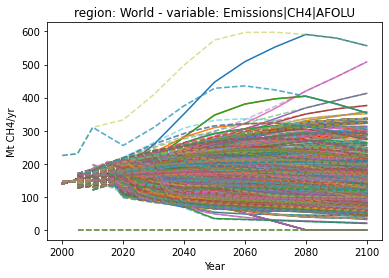

In [48]:
plt.figure()
ax = plt.subplot()
harmedar6ch4afolu.plot(ax=ax)
ar6ch4afolu.plot(ax=ax, linestyle="--", alpha=0.5)

In [49]:
constCH4 = pyam.IamDataFrame(constCH4)

In [50]:
constCH4 = pyam.IamDataFrame(constCH4)
constCH4 = constCH4.timeseries()

In [51]:
def gwpstarfunc(x, biogenic=False, years_to_sum=np.arange(2020, 2051)):
    if biogenic:
        gwp100 = 27.2
    else:
        gwp100 = 29.8    
    a = gwp100 * (0.25 * x[years_to_sum].sum(axis=1))
    b = gwp100 * 0.75 * 100/20 * (x[years_to_sum].values -x[years_to_sum-20].values).sum(axis=1)
    return  1.13 * (a + b)

In [52]:
def reduce_func(ts0, fraction):
    ts = ts0.copy().reset_index()
    ts = ts[(ts.scenario=="SSP2-45") & (ts.model=="MESSAGE-GLOBIOM 1.0")].set_index(ts0.index.names)
    ts[[y for y in ts.columns if (y > 2020)]] = ts[2020].iloc[0]
    declineyears = np.array([y for y in ts.columns if (y > 2020) & (y < 2040)])
    ts[declineyears] *= (1 - (declineyears - 2020)/20 * fraction)
    ts[[y for y in ts.columns if y >= 2040]] *= (1-fraction)
    plt.scatter(ts.columns, ts.iloc[0, :])
    return(ts)

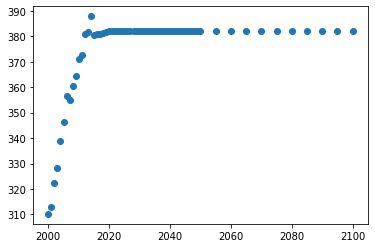

In [53]:
SSP2const = reduce_func(constCH4, 0)
gwpSSP2constCH4 = gwpstarfunc(SSP2const)

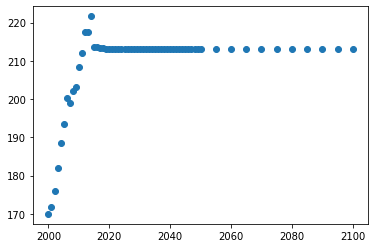

In [54]:
constSSP2ch4notafolu = reduce_func(harmedch4notafolu.timeseries(), 0)

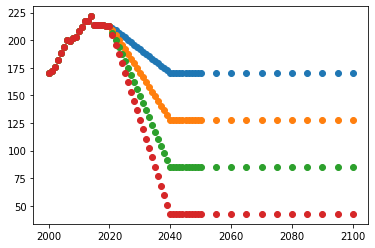

In [55]:
SSP2ch4notafolu20percdec = reduce_func(constSSP2ch4notafolu, 0.2)
SSP2ch4notafolu40percdec = reduce_func(constSSP2ch4notafolu, 0.4)
SSP2ch4notafolu60percdec = reduce_func(constSSP2ch4notafolu, 0.6)
SSP2ch4notafolu80percdec = reduce_func(constSSP2ch4notafolu, 0.8)

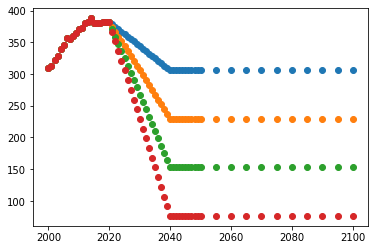

In [56]:
SSP2_20decline = reduce_func(SSP2const, 0.2)
SSP2_40decline = reduce_func(SSP2const, 0.4)
SSP2_60decline = reduce_func(SSP2const, 0.6)
SSP2_80decline = reduce_func(SSP2const, 0.8)

model                scenario  region  variable       unit     
MESSAGE-GLOBIOM 1.0  SSP2-45   World   Emissions|CH4  Mt CH4/yr    155780.561124
dtype: float64

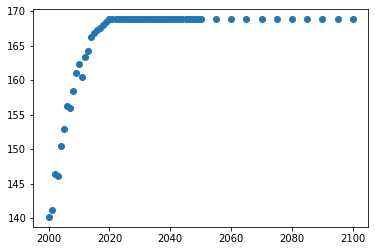

In [57]:
SSP2AFOLUconst = reduce_func(harmedar6ch4afolu.timeseries(), 0)
gwpSSP2constCH4AFOLU = gwpstarfunc(SSP2AFOLUconst, biogenic=True)
gwpSSP2constCH4

In [58]:
SSP2AFOLUconst

2000  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  140.217063   

                                                                         2001  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  141.218913   

                                                                         2002  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  146.432302   

                                                                         2003  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  146.092681   

                                                                         2004  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  150.511569   

                                                                         2005  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  152.959238   

                                                                         2006  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  156.313756   

                                                                         2007  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  156.010978   

                                                                         2008  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  158.439586   

                                                                         2009  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  161.105793   

                                                                   ...  \
model               scenario region variable            unit       ...   
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  ...   

                                                                         2055  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  168.827657   

                                                                         2060  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  168.827657   

                                                                         2065  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  168.827657   

                                                                         2070  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  168.827657   

                                                                         2075  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|CH4|AFOLU Mt CH4/yr  168.827657   

                                                                         2080  \
model               scenario region variable            unit                    
MESSAGE-GLOBIOM 1.0 SSP2-45 

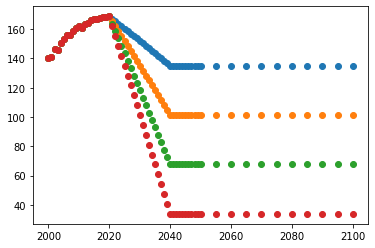

In [59]:
SSP2AFOLU_20decline = reduce_func(SSP2AFOLUconst, 0.2)
SSP2AFOLU_40decline = reduce_func(SSP2AFOLUconst, 0.4)
SSP2AFOLU_60decline = reduce_func(SSP2AFOLUconst, 0.6)
SSP2AFOLU_80decline = reduce_func(SSP2AFOLUconst, 0.8)

In [60]:
def gwpstarn2ofunc(x, years_to_sum=np.arange(2020, 2051)):
    # The GWP100 of N2O is 273 in AR6, but the units are kt
    return x.loc[:, years_to_sum].sum(axis=1) *  273 / 1000

In [61]:
def gwpstarfgasfunc(x, years_to_sum=np.arange(2020, 2051)):
    # Here the units are in MtCO2-eq already
    return x.loc[:, years_to_sum].sum(axis=1)

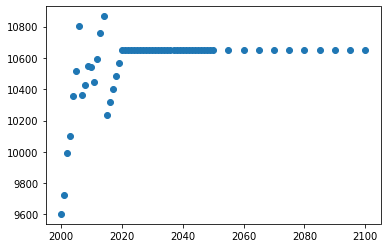

In [62]:
SSP2N2Oconst = reduce_func(constn2o, 0)
gwpSSP2constN2O = gwpstarn2ofunc(SSP2N2Oconst)

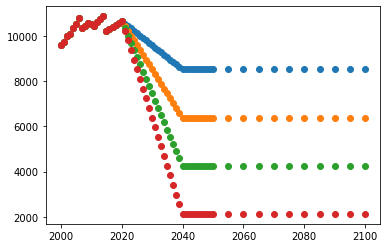

In [63]:
ssp2N2Odec20 = reduce_func(SSP2N2Oconst, 0.2)
ssp2N2Odec40 = reduce_func(SSP2N2Oconst, 0.4)
ssp2N2Odec60 = reduce_func(SSP2N2Oconst, 0.6)
ssp2N2Odec80 = reduce_func(SSP2N2Oconst, 0.8)

In [64]:
gwpSSP2constN2O

model                scenario  region  variable       unit     
MESSAGE-GLOBIOM 1.0  SSP2-45   World   Emissions|N2O  kt N2O/yr    90142.546129
dtype: float64

In [65]:
# Check that if we don't use the different values of GWP100 for different methanes we get the same answers for the components
check = gwpstarfunc(harmedar6ch4afolu.timeseries()).reset_index(
    ["region", "variable", "unit"], drop=True
) + gwpstarfunc(harmedch4notafolu.timeseries()).reset_index(["region", "variable", "unit"], drop=True) - gwpstarfunc(
    constCH4
).reset_index(
    ["region", "variable", "unit"], drop=True)
assert max(check) < 1e-9
np.isnan(check).sum()

435

In [66]:
np.isfinite(gwpstarfunc(harmedar6ch4afolu.timeseries(), biogenic=True)).sum()

1351

In [67]:
gwpstarfunc(constCH4)

model              scenario                region  variable       unit     
AIM/CGE 2.0        ADVANCE_2020_1.5C-2100  World   Emissions|CH4  Mt CH4/yr   -521047.940943
                   ADVANCE_2020_Med2C      World   Emissions|CH4  Mt CH4/yr   -356556.339154
                   ADVANCE_2020_WB2C       World   Emissions|CH4  Mt CH4/yr   -419377.779975
                   ADVANCE_2030_Med2C      World   Emissions|CH4  Mt CH4/yr   -319370.970827
                   ADVANCE_2030_Price1.5C  World   Emissions|CH4  Mt CH4/yr   -410357.803517
                                                                                   ...      
WITCH-GLOBIOM 4.4  CD-LINKS_NPi            World   Emissions|CH4  Mt CH4/yr    286720.939261
                   CD-LINKS_NPi2020_1000   World   Emissions|CH4  Mt CH4/yr   -486598.372502
                   CD-LINKS_NPi2020_1600   World   Emissions|CH4  Mt CH4/yr   -429285.405966
                   CD-LINKS_NPi2020_400    World   Emissions|CH4  Mt CH4/yr   -525741.3

In [68]:
constFgas = pyam.IamDataFrame(constFgas).interpolate(constn2o.columns).timeseries()

C:\Users\rlamboll\Anaconda3\envs\silicone-3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\rlamboll\Anaconda3\envs\silicone-3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\rlamboll\Anaconda3\envs\silicone-3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\rlamboll\Anaconda3\envs\silicone-3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


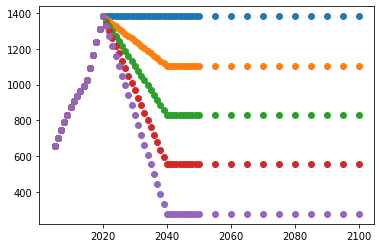

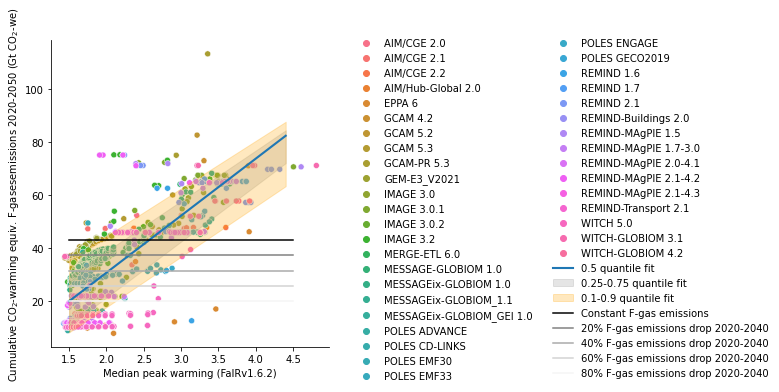

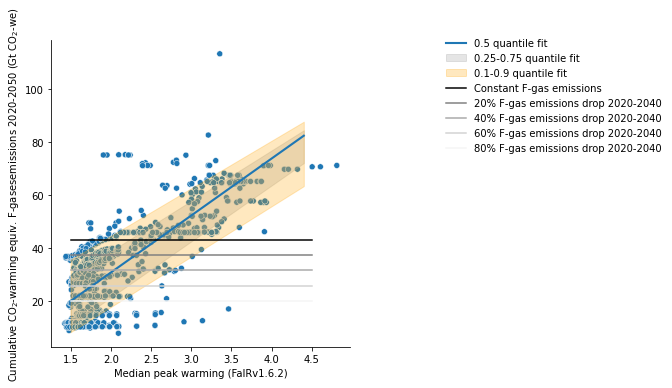

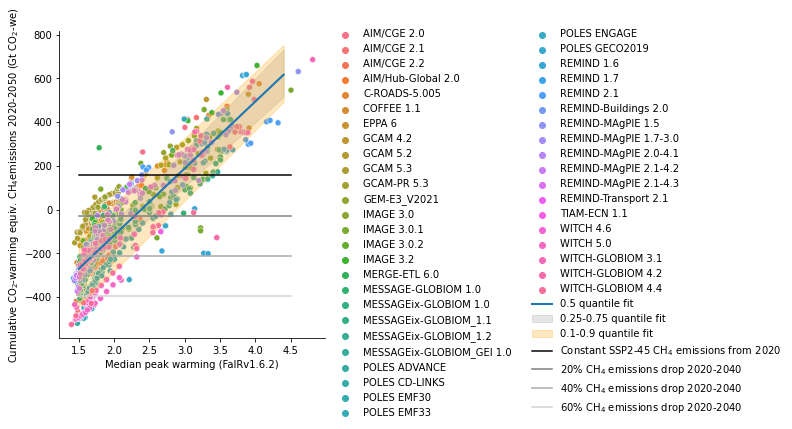

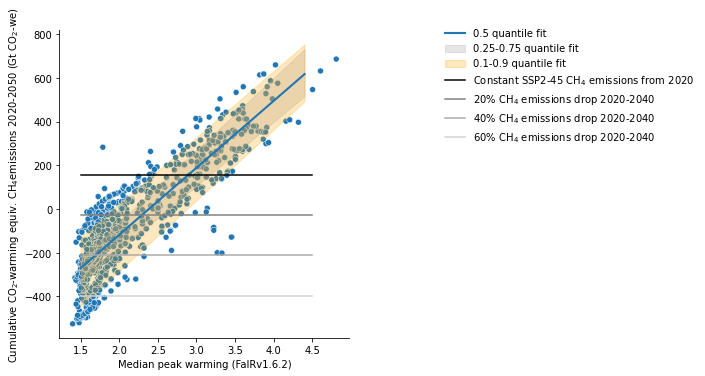

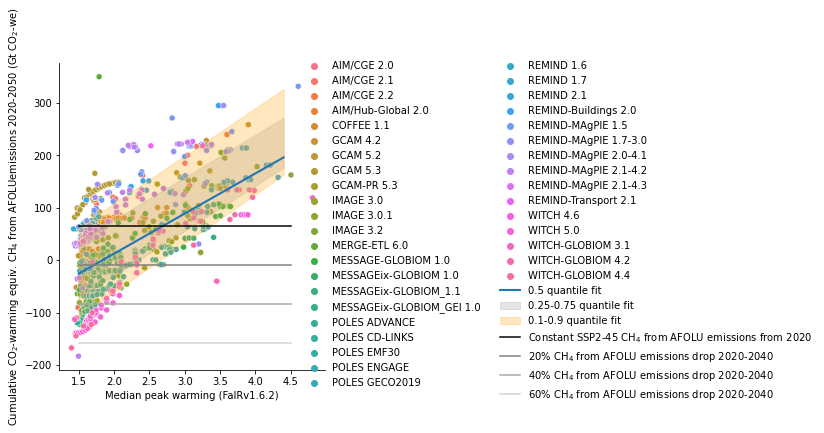

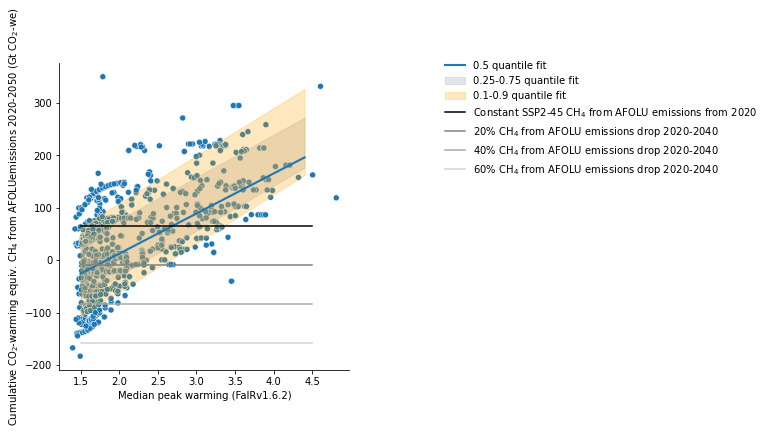

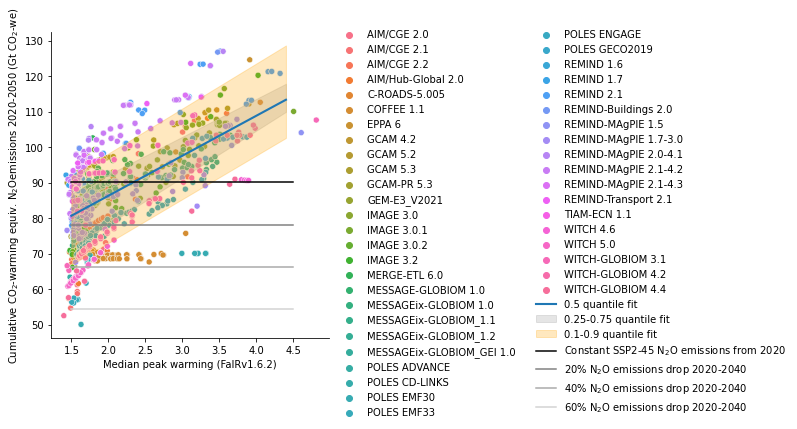

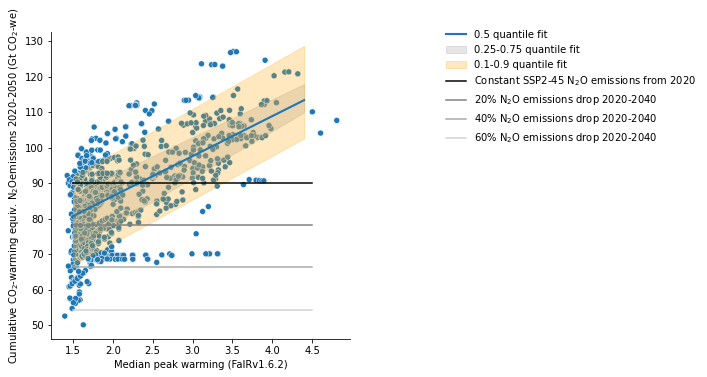

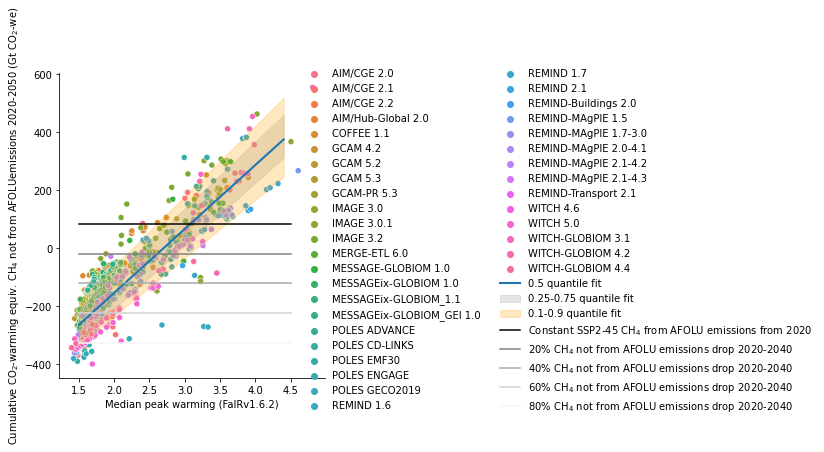

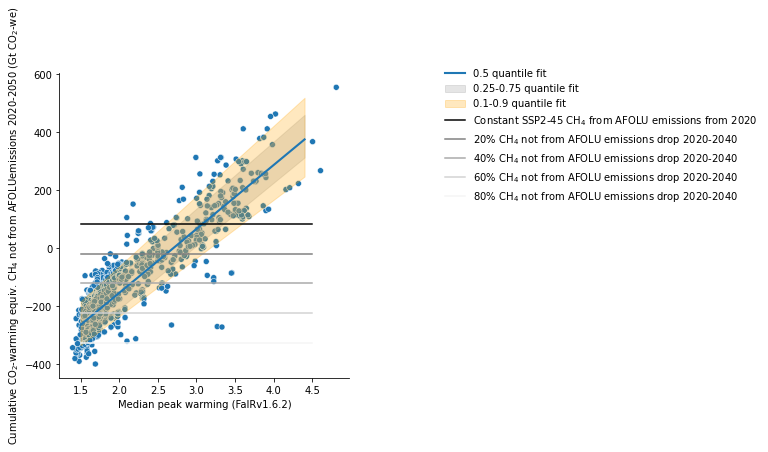

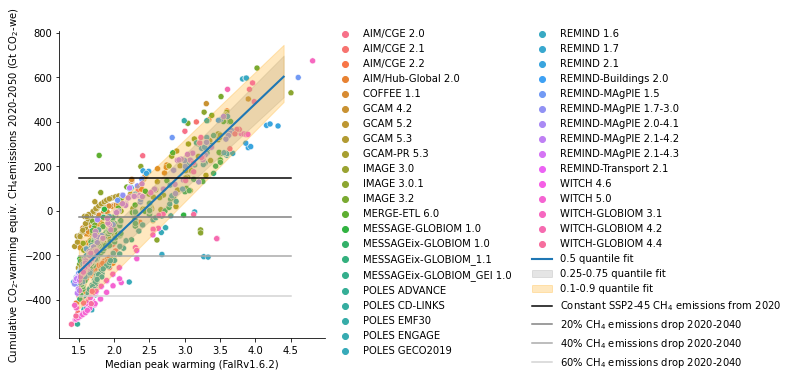

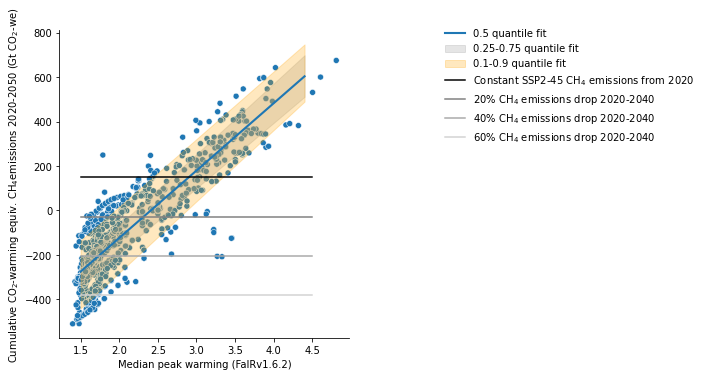

In [69]:
constlines_df = []
all_dfs = {}

if include_qrw:
    all_qrw = []
    qrwstring = "includeQRW"
else:
    qrwstring = ""

colorset = ["black", "grey", "darkgrey", "lightgrey", "whitesmoke"]
for (gwpstar, name, title, constlinesdict) in [
    (gwpstarfgasfunc(constFgas), "FgasGWP", "F-gases", {
        "Constant F-gas emissions": gwpstarfgasfunc(reduce_func(constFgas, 0)),
        "20% F-gas emissions drop 2020-2040": gwpstarfgasfunc(reduce_func(constFgas, 0.2)),
        "40% F-gas emissions drop 2020-2040": gwpstarfgasfunc(reduce_func(constFgas, 0.4)),
        "60% F-gas emissions drop 2020-2040": gwpstarfgasfunc(reduce_func(constFgas, 0.6)),
        "80% F-gas emissions drop 2020-2040": gwpstarfgasfunc(reduce_func(constFgas, 0.8))
    }),
    (gwpstarfunc(constCH4), "CH4GWP", "CH$_4$", {
        "Constant SSP2-45 CH$_4$ emissions from 2020": gwpSSP2constCH4, 
        "20% CH$_4$ emissions drop 2020-2040": gwpstarfunc(SSP2_20decline),
        "40% CH$_4$ emissions drop 2020-2040": gwpstarfunc(SSP2_40decline),
        "60% CH$_4$ emissions drop 2020-2040": gwpstarfunc(SSP2_60decline),
        "*80% CH$_4$ emissions drop 2020-2040": gwpstarfunc(SSP2_80decline),
    }),
         (gwpstarfunc(harmedar6ch4afolu.timeseries(), biogenic=True), "CH4AFOLUGWP", "CH$_4$ from AFOLU", 
     {"Constant SSP2-45 CH$_4$ from AFOLU emissions from 2020": gwpSSP2constCH4AFOLU,
    "20% CH$_4$ from AFOLU emissions drop 2020-2040": gwpstarfunc(SSP2AFOLU_20decline, biogenic=True),
    "40% CH$_4$ from AFOLU emissions drop 2020-2040": gwpstarfunc(SSP2AFOLU_40decline, biogenic=True),
    "60% CH$_4$ from AFOLU emissions drop 2020-2040": gwpstarfunc(SSP2AFOLU_60decline, biogenic=True),
    "*80% CH$_4$ from AFOLU emissions drop 2020-2040": gwpstarfunc(SSP2AFOLU_80decline, biogenic=True),
     }),
    (gwpstarn2ofunc(constn2o), "N2OGWP", "N$_2$O", {
        "Constant SSP2-45 N$_2$O emissions from 2020": gwpSSP2constN2O, 
        "20% N$_2$O emissions drop 2020-2040": gwpstarn2ofunc(ssp2N2Odec20),
        "40% N$_2$O emissions drop 2020-2040": gwpstarn2ofunc(ssp2N2Odec40),
        "60% N$_2$O emissions drop 2020-2040": gwpstarn2ofunc(ssp2N2Odec60),
        "*80% N$_2$O emissions drop 2020-2040": gwpstarn2ofunc(ssp2N2Odec80),
    }), 
    (gwpstarfunc(harmedch4notafolu.timeseries()), "CH4NotAFOLU", "CH$_4$ not from AFOLU", 
    {"Constant SSP2-45 CH$_4$ from AFOLU emissions from 2020": gwpstarfunc(constSSP2ch4notafolu),
    "20% CH$_4$ not from AFOLU emissions drop 2020-2040": gwpstarfunc(SSP2ch4notafolu20percdec), 
    "40% CH$_4$ not from AFOLU emissions drop 2020-2040": gwpstarfunc(SSP2ch4notafolu40percdec), 
    "60% CH$_4$ not from AFOLU emissions drop 2020-2040": gwpstarfunc(SSP2ch4notafolu60percdec), 
    "80% CH$_4$ not from AFOLU emissions drop 2020-2040": gwpstarfunc(SSP2ch4notafolu80percdec), 
    }),
    ((gwpstarfunc(harmedar6ch4afolu.timeseries().reset_index(["region", "variable", "unit"], drop=True), biogenic=True) + 
     gwpstarfunc(harmedch4notafolu.timeseries()).reset_index(["region", "variable", "unit"], drop=True)), 
    "CH4CombinedGWP", "CH$_4$", 
    {"Constant SSP2-45 CH$_4$ emissions from 2020": gwpSSP2constCH4AFOLU + gwpstarfunc(constSSP2ch4notafolu).values,
    "20% CH$_4$ emissions drop 2020-2040": gwpstarfunc(SSP2AFOLU_20decline, biogenic=True) +
    gwpstarfunc(SSP2ch4notafolu20percdec).values,
    "40% CH$_4$ emissions drop 2020-2040": gwpstarfunc(SSP2AFOLU_40decline, biogenic=True) +
    gwpstarfunc(SSP2ch4notafolu40percdec).values,
     "60% CH$_4$ emissions drop 2020-2040": gwpstarfunc(SSP2AFOLU_60decline, biogenic=True) +
    gwpstarfunc(SSP2ch4notafolu60percdec).values,
    }),
]:
    gwpstar.name = name
    varcompare = pd.merge(peakseries, gwpstar/1000, left_index=True, right_index=True)
    alllinresults = {}
    allquantresults = {}
    temps_of_interest = np.arange(1.5, 4.5, 0.1)
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    # Plot this
    for hue in ["model", 1]:
        plot = sns.relplot(data=varcompare, x=peak, y=gwpstar.name, hue=hue, kind="scatter").set(
            ylabel="Cumulative CO$_2$-warming equiv. " + title + "emissions 2020-2050 (Gt CO$_2$-we)")
        # quantile fit
        allquant = {}
        for q in quantiles:
            qr = smf.quantreg('Q(f"{name}") ~ Q(f"{peak}")', varcompare).fit(q=q)
            allquant[q] = {t: qr.params["Intercept"] + qr.params['Q(f"{peak}")'] * t for t in temps_of_interest}
        plt.plot(allquant[0.5].keys(), [i for i in allquant[0.5].values()], 
                     linestyle="-", label=f'{0.5} quantile fit', linewidth=2.1)
        plt.fill_between(
            allquant[0.5].keys(), [i for i in allquant[0.25].values()], [i for i in allquant[0.75].values()],
            label=f'0.25-0.75 quantile fit', alpha=0.3, color="darkgrey"
        )    
        plt.fill_between(
            allquant[0.5].keys(), [i for i in allquant[0.1].values()], [i for i in allquant[0.9].values()],
            label=f'0.1-0.9 quantile fit', alpha=0.25, color="orange"
        )
        if include_qrw:
            # We include the quantile rolling windows in the plot. 
            # This has 35 windows, which approximately are centered at 0.1C intervals.
            qrw = rolling_window_find_quantiles(varcompare[peak], varcompare[name], 0.5, 35)
            plt.plot(qrw.index, qrw.values)
            if hue==1:
                qrw.to_csv(f"./output/QRW_tabulated_{name}_{version}.csv")
        
        dictnum=0
        for key, constline in constlinesdict.items():
            if key[0] != "*":
                plt.plot([1.5, 4.5], [constline.values[0]/1000, constline.values[0]/1000], label=key, color=colorset[dictnum])
                dictnum += 1
            if hue != 1:
                constlines_df.append([name, key, constline.values[0]])
        # sort legend out
        handles, labels = plot.axes[0][0].get_legend_handles_labels()
        plot._legend.remove()
        if hue != 1:
            lgd = plot.fig.legend(handles, labels, ncol=2, loc='upper center', 
                        bbox_to_anchor=(1.08, 1), frameon=False)
        else:
            lgd = plot.fig.legend(handles[1:], labels[1:], ncol=1, loc='upper left', 
                        bbox_to_anchor=(1.1, 1), frameon=False)
        plt.savefig(
            f"./output/figures/{gwpstar.name}CumSumregression_fit_{version}_{hue}{qrwstring}.pdf", 
            bbox_extra_artists=(lgd,), bbox_inches='tight'
        )
        plt.savefig(
            f"./output/figures/{gwpstar.name}_CumSumregression_fit_{version}_{hue}{qrwstring}.png", 
            bbox_extra_artists=(lgd,), bbox_inches='tight', format="png"
        )
    quantdf = []
    for key2, inner_inner_dict in allquant.items():
        # Create a new dictionary with the flattened entries
        for key3, val in inner_inner_dict.items():
            flattened_entry = {
                'Quantile': key2,
                "temperature": key3,
                name: val
            }
            # Append the flattened entry to the list
            quantdf.append(flattened_entry)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(quantdf)
    df.to_csv(f"./output/tabulated_{name}_{version}.csv")
    all_dfs[name] = df

In [70]:
f"./output/figures/{gwpstar.name}CumSumregression_fit_{version}_{hue}.pdf"

'./output/figures/CH4CombinedGWPCumSumregression_fit_v6_1.pdf'

In [71]:
constlines_df = pd.DataFrame(constlines_df, columns=["Gas", "Title", "GWPstar"])
constlines_df

Gas                                              Title  \
0          FgasGWP                           Constant F-gas emissions   
1          FgasGWP                 20% F-gas emissions drop 2020-2040   
2          FgasGWP                 40% F-gas emissions drop 2020-2040   
3          FgasGWP                 60% F-gas emissions drop 2020-2040   
4          FgasGWP                 80% F-gas emissions drop 2020-2040   
5           CH4GWP        Constant SSP2-45 CH$_4$ emissions from 2020   
6           CH4GWP                20% CH$_4$ emissions drop 2020-2040   
7           CH4GWP                40% CH$_4$ emissions drop 2020-2040   
8           CH4GWP                60% CH$_4$ emissions drop 2020-2040   
9           CH4GWP               *80% CH$_4$ emissions drop 2020-2040   
10     CH4AFOLUGWP  Constant SSP2-45 CH$_4$ from AFOLU emissions f...   
11     CH4AFOLUGWP     20% CH$_4$ from AFOLU emissions drop 2020-2040   
12     CH4AFOLUGWP     40% CH$_4$ from AFOLU emissions drop 2020-2040   
13     CH4AFOLUGWP     60% CH$_4$ from AFOLU emissions drop 2020-2040   
14     CH4AFOLUGWP    *80% CH$_4$ from AFOLU emissions drop 2020-2040   
15          N2OGWP        Constant SSP2-45 N$_2$O emissions from 2020   
16          N2OGWP                20% N$_2$O emissions drop 2020-2040   
17          N2OGWP                40% N$_2$O emissions drop 2020-2040   
18          N2OGWP                60% N$_2$O emissions drop 2020-2040   
19          N2OGWP               *80% N$_2$O emissions drop 2020-2040   
20     CH4NotAFOLU  Constant SSP2-45 CH$_4$ from AFOLU emissions f...   
21     CH4NotAFOLU  20% CH$_4$ not from AFOLU emissions drop 2020-...   
22     CH4NotAFOLU  40% CH$_4$ not from AFOLU emissions drop 2020-...   
23     CH4NotAFOLU  60% CH$_4$ not from AFOLU emissions drop 2020-...   
24     CH4NotAFOLU  80% CH$_4$ not from AFOLU emissions drop 2020-...   
25  CH4CombinedGWP        Constant SSP2-45 CH$_4$ emissions from 2020   
26  CH4CombinedGWP                20% CH$_4$ emissions drop 2020-2040   
27  CH4CombinedGWP                40% CH$_4$ emissions drop 2020-2040   
28  CH4CombinedGWP                60% CH$_4$ emissions drop 2020-2040   

          GWPstar  
0    42864.866276  
1    37195.642027  
2    31526.417777  
3    25857.193528  
4    20187.969278  
5   155780.561124  
6   -28607.979576  
7  -212996.520277  
8  -397385.060977  
9  -581773.601678  
10   64711.551531  
11   -9686.981410  
12  -84085.514351  
13 -158484.047293  
14 -232882.580234  
15   90142.546129  
16   78220.467448  
17   66298.388766  
18   54376.310085  
19   42454.231403  
20   84883.346579  
21  -17995.036708  
22 -120873.419995  
23 -223751.803281  
24 -326630.186568  
25  149594.898110  
26  -27682.018118  
27 -204958.934346  
28 -382235.850574

In [72]:
constlines_df.to_csv(f"./output/constant_line_values_{version}.csv")

In [73]:
allconstlines = []
for key, val in all_dfs.items():
    for temp in [1.5, 1.7, 2.0]:
        new_constlines = constlines_df.copy()
        new_constlines["Warming"] = temp
        new_constlines["Diff"] = np.nan
        inds = (new_constlines["Gas"]==key)
        new_constlines.loc[inds, "Diff"] = val.loc[
            np.isclose(val["temperature"], temp) & (val["Quantile"]==0.5), :
        ].iloc[:, -1].values[0] - new_constlines.loc[inds, "GWPstar"] / 1000
        allconstlines.append(new_constlines.loc[inds, :])
allconstlines = pd.concat(allconstlines)

In [74]:
allconstlines.head()

Gas                               Title       GWPstar  Warming  \
0  FgasGWP            Constant F-gas emissions  42864.866276      1.5   
1  FgasGWP  20% F-gas emissions drop 2020-2040  37195.642027      1.5   
2  FgasGWP  40% F-gas emissions drop 2020-2040  31526.417777      1.5   
3  FgasGWP  60% F-gas emissions drop 2020-2040  25857.193528      1.5   
4  FgasGWP  80% F-gas emissions drop 2020-2040  20187.969278      1.5   

        Diff  
0 -22.883138  
1 -17.213914  
2 -11.544690  
3  -5.875465  
4  -0.206241

In [75]:
allconstlines.to_csv(f"./output/expectedGWPminusconstant_line_values_{version}.csv")

In [76]:
# Finally compare the analysis for 2030 and 2040 emissions sums
temps_of_interest = [1.5, 1.7, 2.0]
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
for year in [2030, 2040]:
    sumyears = np.arange(2020, year+1)
    all_dfs = {}
    for (gwpstar, name) in [
        (gwpstarfunc(constCH4, years_to_sum=sumyears), "CH4GWP"),
        (gwpstarfunc(harmedar6ch4afolu.timeseries(), biogenic=True, years_to_sum=sumyears), "CH4AFOLUGWP"),
        (gwpstarn2ofunc(constn2o, years_to_sum=sumyears), "N2OGWP"), 
        (gwpstarfunc(harmedch4notafolu.timeseries(), years_to_sum=sumyears), "CH4NotAFOLU"),
        ((gwpstarfunc(
            harmedar6ch4afolu.timeseries().reset_index(["region", "variable", "unit"], drop=True), 
            biogenic=True, years_to_sum=sumyears) + 
         gwpstarfunc(
             harmedch4notafolu.timeseries(), years_to_sum=sumyears).reset_index(
             ["region", "variable", "unit"], drop=True)
        ), "CH4CombinedGWP"),
        (gwpstarfgasfunc(constFgas, years_to_sum=sumyears), "FgasGWP")
    ]:
        gwpstar.name = name
        varcompare = pd.merge(peakseries, gwpstar/1000, left_index=True, right_index=True)
        alllinresults = {}
        allquantresults = {}
        # quantile fit
        allquant = {}
        for q in quantiles:
            qr = smf.quantreg('Q(f"{name}") ~ Q(f"{peak}")', varcompare).fit(q=q)
            allquant[q] = {t: qr.params["Intercept"] + qr.params['Q(f"{peak}")'] * t for t in temps_of_interest}
        quantdf = []
        for key2, inner_inner_dict in allquant.items():
            # Create a new dictionary with the flattened entries
            for key3, val in inner_inner_dict.items():
                flattened_entry = {
                    'Quantile': key2,
                    "temperature": key3,
                    name: round(val)
                    }
                # Append the flattened entry to the list
                quantdf.append(flattened_entry)

        # Convert the list of dictionaries to a DataFrame
        df = pd.DataFrame(quantdf).sort_values(["temperature", "Quantile"])
        df.to_csv(f"./output/Year_{year}_tabulated_{name}_{version}.csv")

In [77]:
df

Quantile  temperature  FgasGWP
0       0.10          1.5        8
3       0.25          1.5       10
6       0.50          1.5       19
9       0.75          1.5       23
12      0.90          1.5       26
1       0.10          1.7       10
4       0.25          1.7       12
7       0.50          1.7       21
10      0.75          1.7       25
13      0.90          1.7       28
2       0.10          2.0       13
5       0.25          2.0       16
8       0.50          2.0       24
11      0.75          2.0       28
14      0.90          2.0       30

# Draw plots of emissions verses time with some temperatures highlighted

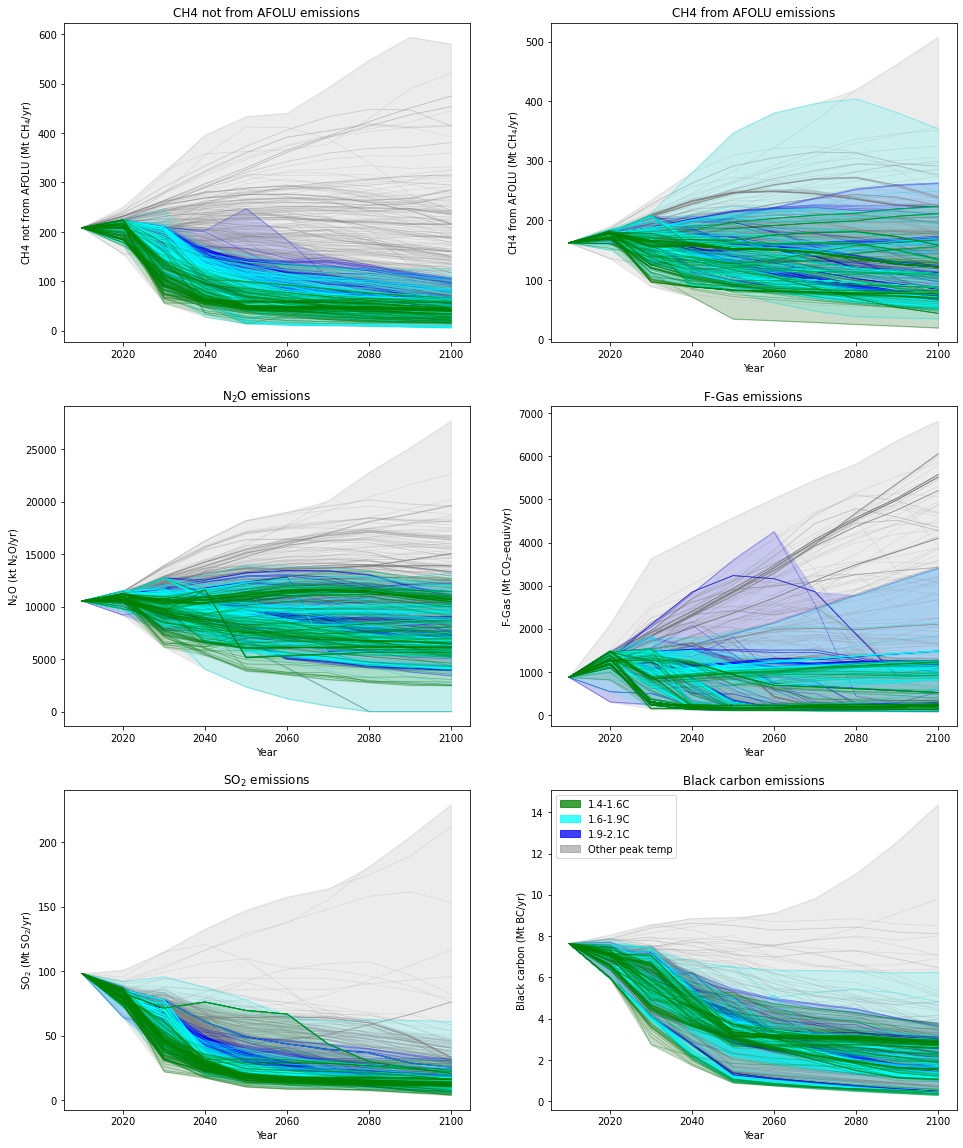

In [78]:
plt.figure(figsize=(16, 20))
years = np.arange(2010, 2101, 10)
i=1
for gas, dfgas, unit in [
    ("CH4 not from AFOLU", harmedch4notafolu.timeseries(), "Mt CH$_4$/yr"),
    ("CH4 from AFOLU", harmedar6ch4afolu.timeseries(), "Mt CH$_4$/yr"), 
    ("N$_2$O", constn2o, "kt N$_2$O/yr"), 
    ("F-Gas", constFgas, "Mt CO$_2$-equiv/yr"), 
    ("SO$_2%$", constsulf, "Mt SO$_2$/yr"), 
    ("Black carbon", constBC, "Mt BC/yr")
]:
    ax = plt.subplot(3, 2, i)
    i += 1
    dfgasmeta = pd.merge(
        dfgas.reset_index(["region", "variable", "unit"]).reset_index(), 
        peakseries.reset_index(),
    )
    
    plt.fill_between(years, dfgasmeta[years].min(), dfgasmeta[years].max(), alpha=0.15, color="grey")
    dfgasmeta.loc[:, years].T.plot(legend=None, color="grey", alpha=0.18, linewidth=0.7, ax=ax, label="Other peak temp")
    for templo, temphi, color in [(1.9, 2.1, "blue"), (1.6, 1.9, "cyan"), (1.4, 1.6, "green")]:
        dfgastemp = dfgasmeta.loc[(dfgasmeta[peak]<temphi)&(dfgasmeta[peak]>templo), years]
        dfgastemp.T.plot(
            legend=None, color=color, linewidth=0.8, ax=ax, alpha=0.3, label=f"{templo}-{temphi}C"
        )
        plt.fill_between(years, dfgastemp[years].min(), dfgastemp[years].max(), alpha=0.15, color=color)
        plt.title(gas + " emissions")
    plt.xlabel("Year")
    plt.ylabel(f"{gas} ({unit})")
plt.legend(handles=[
    Patch(color="green", label="1.4-1.6C", alpha = 0.75), 
    Patch(color="cyan", label="1.6-1.9C", alpha = 0.75), 
    Patch(color="blue", label="1.9-2.1C", alpha = 0.75), 
    Patch(color="grey", label="Other peak temp", alpha = 0.5)
])
plt.savefig(
    f"./output/figures/Emissionsplots_{harmstatus}_{version}.png", bbox_extra_artists=(lgd,), bbox_inches='tight'
)